# YouTube Video Popularity
COMP-4448: Data Science Tools 2<br>
Final Project<br>
May 29, 2023<br>
Sammantha Firestone, Jacquelyn Noyes

In [1]:
## libraries for data manipulation and visualization
import pandas as pd 
pd.set_option('display.float_format', '{:.2f}'.format)
import numpy as np
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from wordcloud import WordCloud
from prettytable import PrettyTable

## libraries for text processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re
import unicodedata
'''
# only need to do once
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('stopwords')
'''

# libraries for machine learning
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

print('Version of libraries used in this project:')
print('pandas version: ', pd.__version__)
print('numpy version: ', np.__version__)
print('matplotlib version: ', matplotlib.__version__)
print('seaborn version: ', sns.__version__)
print('nltk version: ', nltk.__version__)
print('sklearn version: ', sklearn.__version__)

import time
import warnings
warnings.filterwarnings('ignore')

Version of libraries used in this project:
pandas version:  1.5.3
numpy version:  1.24.3
matplotlib version:  3.7.1
seaborn version:  0.12.2
nltk version:  3.7
sklearn version:  1.2.1


## Importing our Data

We obtained the [Trending YouTube Video Statistics](https://www.kaggle.com/datasets/datasnaek/youtube-new?select=USvideos.csv) from Kaggle. This dataset contains data on trending YouTube videos in the US from November 2017 to June 2018. The data was collected using the YouTube API. The dataset contains 16 columns and 40,949 rows. 

In [2]:
# import the US-based youtube dataset
df = pd.read_csv('USvideos.csv')

df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


For this analysis, we will be removing the following columns from our dataset:
- `video_id`: This is a unique identifier for each video, and is not useful for our analysis.
- `trending_date`: This is the date that the video was trending on YouTube; we are more interested in the date that the video was published.
- `thumbnail_link`: This is a link to the thumbnail image for the video; we will not be importing and analyzing image data in this analysis and modeling.
- `comments_disabled`: This is a boolean value that indicates whether comments were disabled for the video; we will not be taking comments into consideration for this analysis and modeling.
- `ratings_disabled`: This is a boolean value that indicates whether ratings were disabled for the video; we will be using ratings as a key indicator of popularity, so we will not be taking this into consideration for this analysis and modeling.
- `video_error_or_removed`: This is a boolean value that indicates whether the video was removed due to an error; we will not be taking this into consideration for this analysis and modeling as we don't care if a video was removed -- only if it was once popular.

In [3]:
columns_to_drop = ['video_id', 'trending_date', 'thumbnail_link', 'comments_disabled', 'ratings_disabled', 'video_error_or_removed', 'comment_count']
df.drop(columns_to_drop, inplace=True, axis=1)

df.head()

,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,description
0,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,"One year after the presidential election, John..."
2,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,Today we find out if Link is a Nickelback amat...
4,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,I know it's been a while since we did this sho...


In [4]:
df.isnull().sum()

title              0
channel_title      0
category_id        0
publish_time       0
tags               0
views              0
likes              0
dislikes           0
description      570
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40949 entries, 0 to 40948
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          40949 non-null  object
 1   channel_title  40949 non-null  object
 2   category_id    40949 non-null  int64 
 3   publish_time   40949 non-null  object
 4   tags           40949 non-null  object
 5   views          40949 non-null  int64 
 6   likes          40949 non-null  int64 
 7   dislikes       40949 non-null  int64 
 8   description    40379 non-null  object
dtypes: int64(4), object(5)
memory usage: 2.8+ MB


## Creating our target variable (`is_popular`)

For this analysis, we will be creating our own target variable called `is_popular`. To calculate whether or not a video is popular, YouTube uses an engagement score formula that takes in account of all the different ways a user can interact with a video. This can include liking or disliking a video, commenting or sharing a video, but because there are videos that have comments disabled, we will focus on likes and dislikes for our analysis. Thus, we will be using the following formula to calculate our own engagement score:

$$
\begin{align}
\text{Engagement Score} = \frac{\text{likes} + \text{dislikes}}{\text{views}}
\end{align}
$$

Before we can calculate our engagement score, we will need to understand and clean our data a bit more. First let's take a look at the distribution of our input variables.

In [6]:
print("Summary Stats on Views")
print(df['views'].describe())
print("\nSummary Stats on Likes")
print(df['likes'].describe())
print("\nSummary Stats on Dislikes")
print(df['dislikes'].describe())

Summary Stats on Views
count       40949.00
mean      2360784.64
std       7394113.76
min           549.00
25%        242329.00
50%        681861.00
75%       1823157.00
max     225211923.00
Name: views, dtype: float64

Summary Stats on Likes
count     40949.00
mean      74266.70
std      228885.34
min           0.00
25%        5424.00
50%       18091.00
75%       55417.00
max     5613827.00
Name: likes, dtype: float64

Summary Stats on Dislikes
count     40949.00
mean       3711.40
std       29029.71
min           0.00
25%         202.00
50%         631.00
75%        1938.00
max     1674420.00
Name: dislikes, dtype: float64


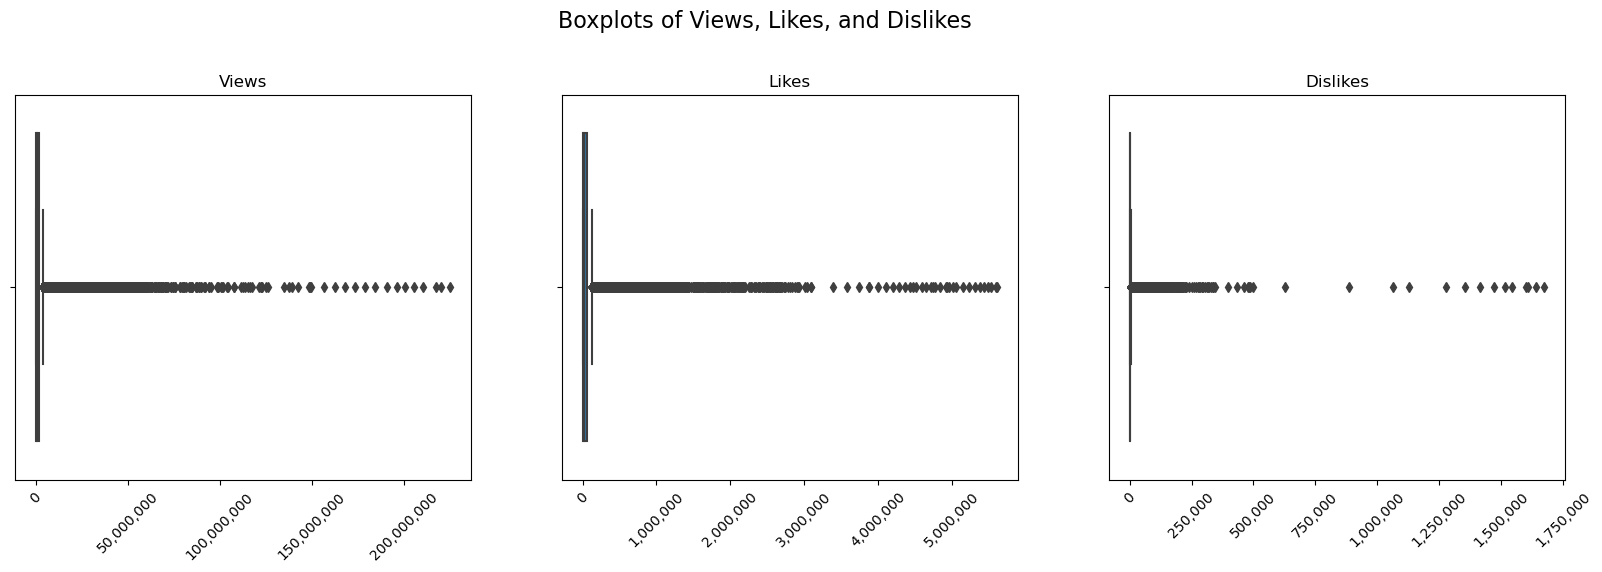

In [7]:
figure, axes = plt.subplots(1, 3, figsize=(20, 5))

# views
sns.boxplot(ax=axes[0], data=df, x='views')
axes[0].set_title('Views')

# likes
sns.boxplot(ax=axes[1], data=df, x='likes')
axes[1].set_title('Likes')

# dislikes
sns.boxplot(ax=axes[2], data=df, x='dislikes')
axes[2].set_title('Dislikes')

for ax in axes:
    ax.ticklabel_format(style='plain', axis='x') # remove scientific notation
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45) # rotate x-axis labels
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: format(int(x), ','))) # add commas to x-axis
    ax.set_xlabel('') # remove x-axis label


figure.suptitle('Boxplots of Views, Likes, and Dislikes', y=1.05, fontsize=16)

plt.show()

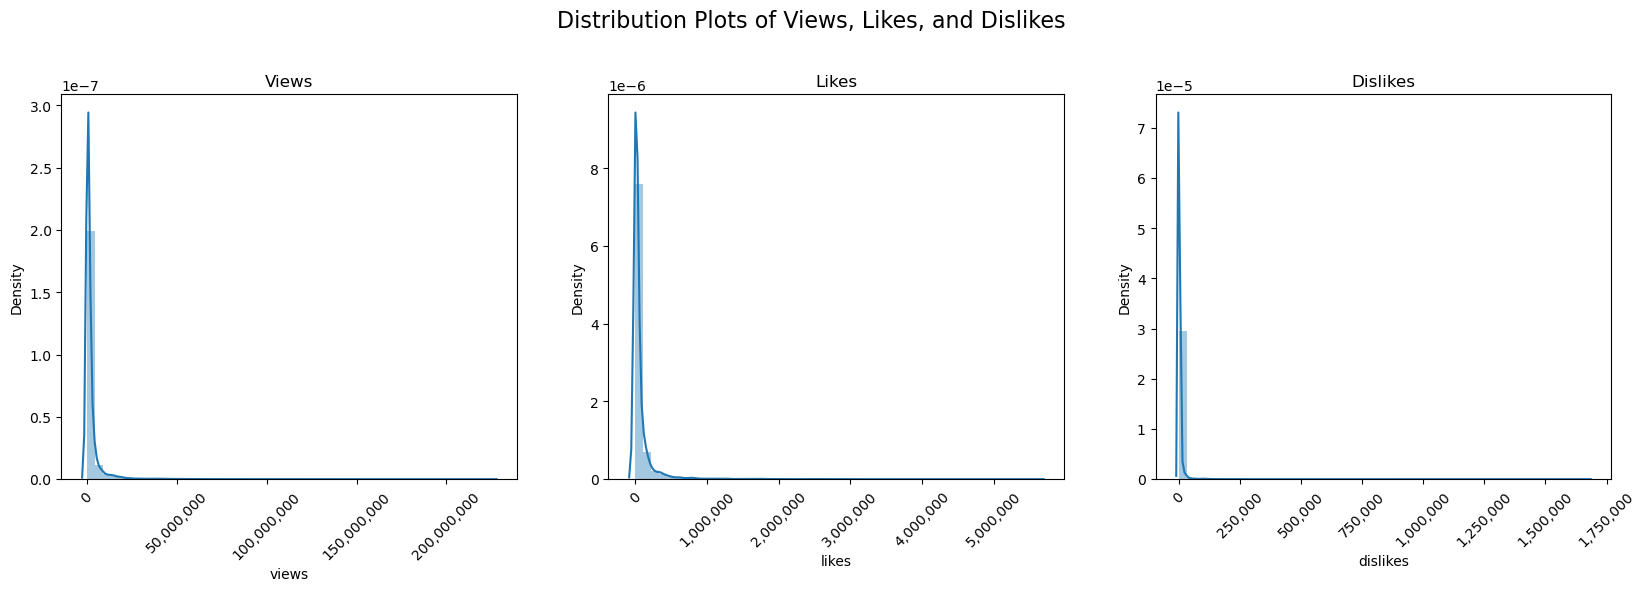

In [8]:
figure, axes = plt.subplots(1, 3, figsize=(20, 5))

# views
sns.distplot(df['views'], ax=axes[0])
axes[0].set_title('Views')

# likes
sns.distplot(df['likes'], ax=axes[1])
axes[1].set_title('Likes')

# dislikes
sns.distplot(df['dislikes'], ax=axes[2])    
axes[2].set_title('Dislikes')

for ax in axes:
    ax.ticklabel_format(style='plain', axis='x') # remove scientific notation
    #ax.ticklabel_format(style='plain', axis='y') # remove scientific notation
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45) # rotate x-axis labels
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: format(int(x), ','))) # add commas to x-axis


figure.suptitle('Distribution Plots of Views, Likes, and Dislikes', y=1.05, fontsize=16)

plt.show()

Based on our description, box-and-whisker, and distribution plot, it appears all of our input variables for our engagement score are highly-skewed right. We can try to normalize our data by taking the log of each variable.

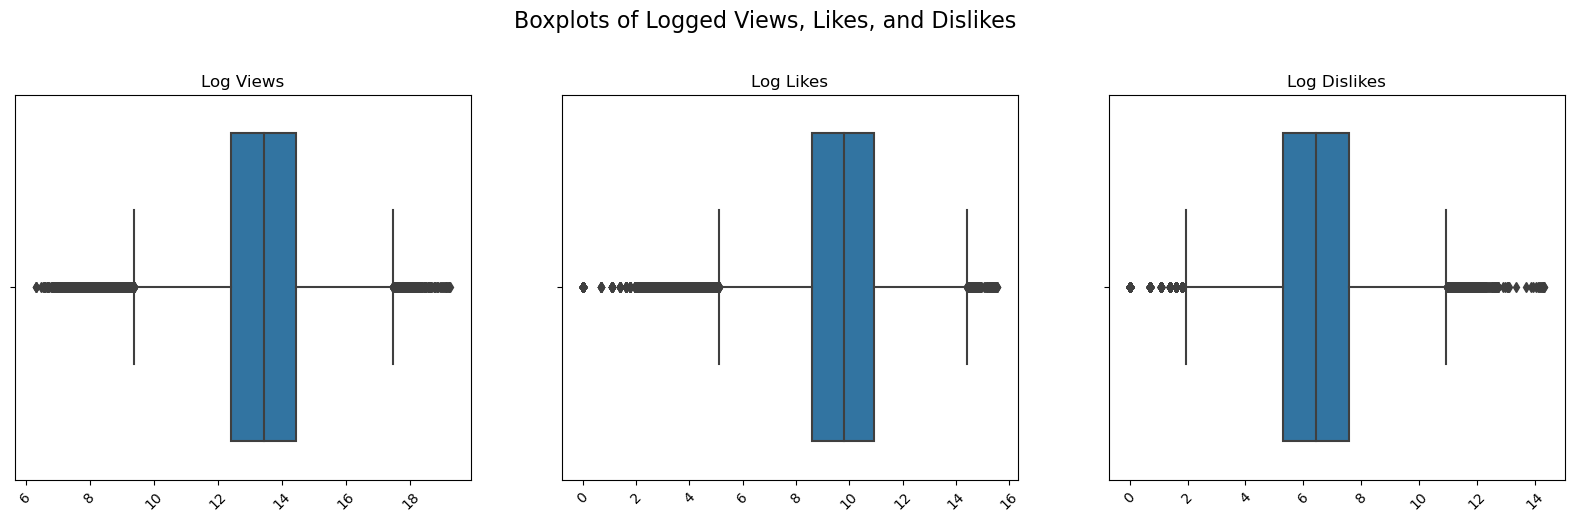

In [9]:
# create log columns for `views` `likes` `dislikes`
df['log_views'] = np.log(df['views'] + 1)
df['log_likes'] = np.log(df['likes'] + 1)
df['log_dislikes'] = np.log(df['dislikes'] + 1)

# create boxplots of log columns
figure, axes = plt.subplots(1, 3, figsize=(20, 5))

# log_views
sns.boxplot(ax=axes[0], data=df, x='log_views')
axes[0].set_title('Log Views')

# log_likes
sns.boxplot(ax=axes[1], data=df, x='log_likes')
axes[1].set_title('Log Likes')

# log_dislikes
sns.boxplot(ax=axes[2], data=df, x='log_dislikes')
axes[2].set_title('Log Dislikes')

for ax in axes:
    ax.ticklabel_format(style='plain', axis='x') # remove scientific notation
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45) # rotate x-axis labels
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: format(int(x), ','))) # add commas to x-axis
    ax.set_xlabel('') # remove x-axis label

figure.suptitle('Boxplots of Logged Views, Likes, and Dislikes', y=1.05, fontsize=16)

plt.show()

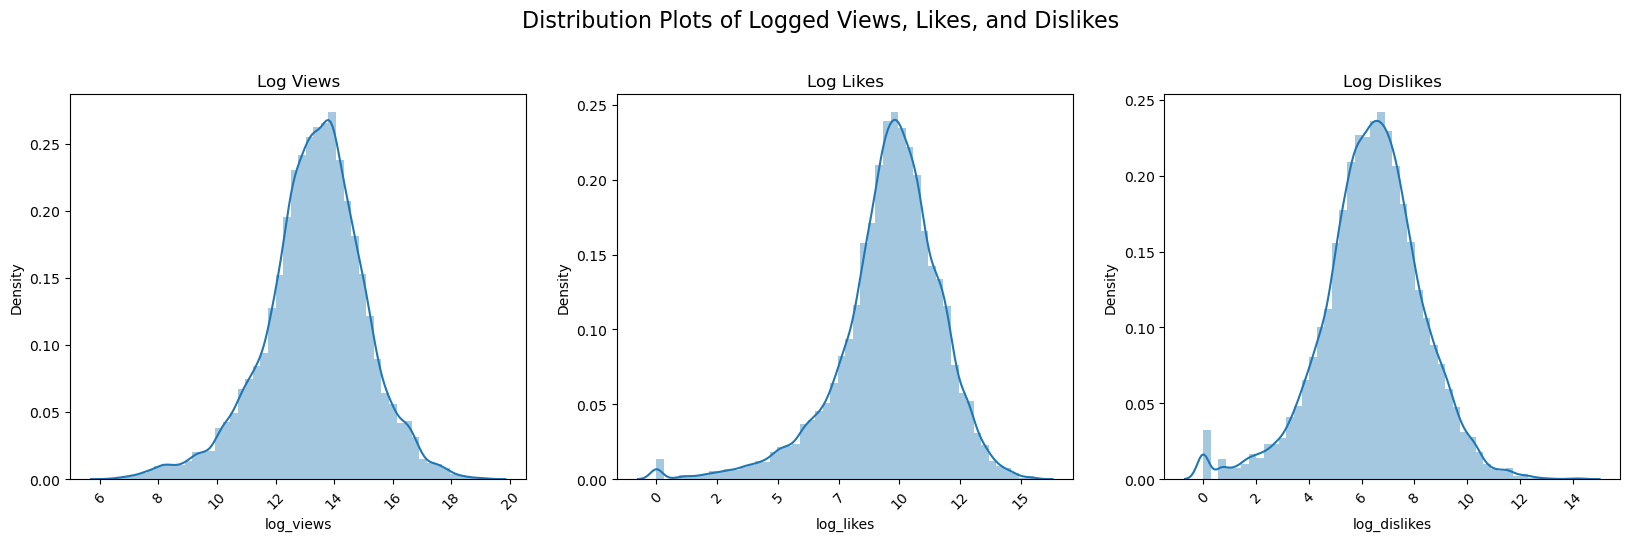

In [10]:
# create distribution plots for log columns
figure, axes = plt.subplots(1, 3, figsize=(20, 5))

# log_views
sns.distplot(df['log_views'], ax=axes[0])
axes[0].set_title('Log Views')

# log_likes
sns.distplot(df['log_likes'], ax=axes[1])
axes[1].set_title('Log Likes')

# log_dislikes
sns.distplot(df['log_dislikes'], ax=axes[2])
axes[2].set_title('Log Dislikes')

for ax in axes:
    ax.ticklabel_format(style='plain', axis='x') # remove scientific notation
    #ax.ticklabel_format(style='plain', axis='y') # remove scientific notation
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45) # rotate x-axis labels
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: format(int(x), ','))) # add commas to x-axis

figure.suptitle('Distribution Plots of Logged Views, Likes, and Dislikes', y=1.05, fontsize=16)

plt.show()

After log-transformation, the `views`, `likes`, and `dislikes` follow a fairly normal distribution. We can now calculate our engagement score with our log-transformed data and our original data to see how the engagement scores differ.

In [11]:
# create engagement score columns
df['engagement_score_log'] = (df['log_likes'] + df['log_dislikes']) / df['log_views']
df['engagement_score'] = (df['likes'] + df['dislikes']) / df['views']

df.head()

,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,description,log_views,log_likes,log_dislikes,engagement_score_log,engagement_score
0,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,SHANTELL'S CHANNEL - https://www.youtube.com/s...,13.53,10.96,8.00,1.40,0.08
1,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,"One year after the presidential election, John...",14.70,11.48,8.72,1.37,0.04
2,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,14.98,11.89,8.58,1.37,0.05
3,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,Today we find out if Link is a Nickelback amat...,12.75,9.23,6.50,1.23,0.03
4,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,I know it's been a while since we did this sho...,14.56,11.79,7.60,1.33,0.06


In [12]:
# get stats for engagement score
print('Engagement Score Stats')
print(df['engagement_score'].describe())
print('Engagement Score Log Stats')
print(df['engagement_score_log'].describe())

Engagement Score Stats
count   40949.00
mean        0.04
std         0.03
min         0.00
25%         0.02
50%         0.03
75%         0.05
max         0.29
Name: engagement_score, dtype: float64
Engagement Score Log Stats
count   40949.00
mean        1.18
std         0.19
min         0.00
25%         1.12
50%         1.22
75%         1.30
max         1.65
Name: engagement_score_log, dtype: float64


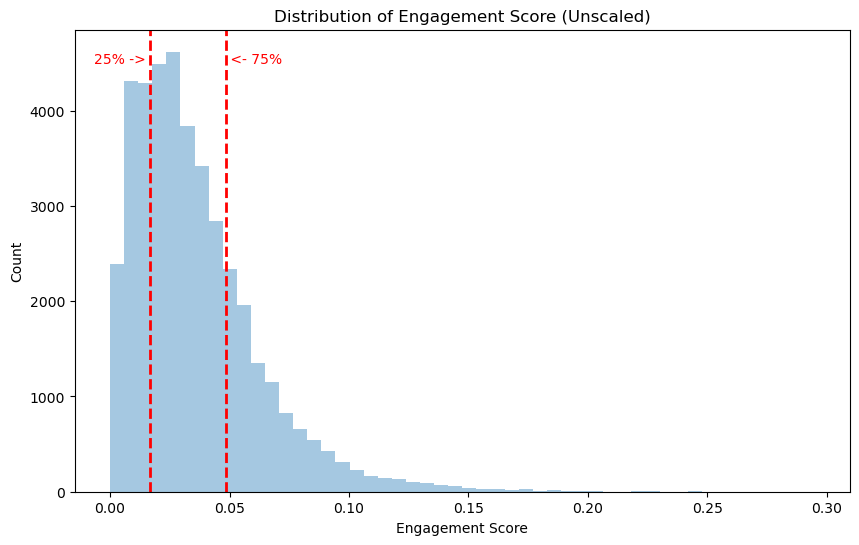

In [13]:
# plot the unscaled data
plt.figure(figsize=(10, 6))
sns.distplot(df['engagement_score'], kde=False)
plt.title('Distribution of Engagement Score (Unscaled)')
plt.xlabel('Engagement Score')
plt.ylabel('Count')
# add line at interquartile range
plt.axvline(df['engagement_score'].describe()['25%'], color='red', linestyle='dashed', linewidth=2)
plt.axvline(df['engagement_score'].describe()['75%'], color='red', linestyle='dashed', linewidth=2)
# add text to indicate interquartile range
plt.text(df['engagement_score'].describe()['25%'], 4500, '25% -> ', color='red', ha='right')
plt.text(df['engagement_score'].describe()['75%'], 4500, ' <- 75%', color='red', ha='left')
plt.show()

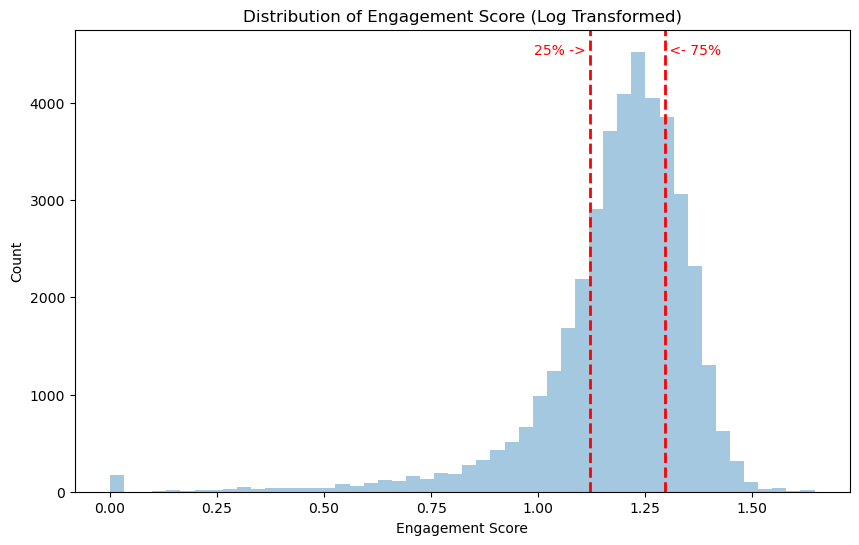

In [14]:
# plot the log-transformed data
plt.figure(figsize=(10, 6))
sns.distplot(df['engagement_score_log'], kde=False)
plt.title('Distribution of Engagement Score (Log Transformed)')
plt.xlabel('Engagement Score')
plt.ylabel('Count')
# add line at interquartile range
plt.axvline(df['engagement_score_log'].describe()['25%'], color='red', linestyle='dashed', linewidth=2)
plt.axvline(df['engagement_score_log'].describe()['75%'], color='red', linestyle='dashed', linewidth=2)
# add text to indicate interquartile range
plt.text(df['engagement_score_log'].describe()['25%'], 4500, '25% -> ', color='red', ha='right')
plt.text(df['engagement_score_log'].describe()['75%'], 4500, ' <- 75%', color='red', ha='left')
plt.show()

It appears that the engagement score of the log-transformed data is much more normally distributed than the original data. Thus, we will use the log-transformed data to calculate our engagement score.

We will use the 75% interquartile range as the threshold to deem something popular or not. This means that if a video's engagement score is greater than the 75% interquartile range, then it is considered popular. Otherwise, it is not popular.

In [15]:
popularity_threshold = df['engagement_score_log'].describe()['75%']
print('Popularity Threshold:', popularity_threshold)

Popularity Threshold: 1.2950703729416098


We can take a look at which videos are most popular in accordance to our engagement score.

In [16]:
# check which videos have the highest engagement score with unique videos
df_unique = df.drop_duplicates(subset='title') # drop duplicate videos in case of re-uploads
print('\nTop 10 Videos with Highest Engagement Score\n')
print(df_unique.sort_values(by='engagement_score_log', ascending=False).head(10))


Top 10 Videos with Highest Engagement Score

                                                   title      channel_title  \
10000                                          So Sorry.   Logan Paul Vlogs   
14000                         Suicide: Be Here Tomorrow.   Logan Paul Vlogs   
16825                                LOGAN PAUL IS BACK!   Logan Paul Vlogs   
39549                         #ProudToCreate: Pride 2018  YouTube Spotlight   
4600   YouTube Rewind: The Shape of 2017 | #YouTubeRe...  YouTube Spotlight   
5602   Logan Paul - SANTA DISS TRACK (Official Music ...   Logan Paul Vlogs   
35752  Official Call of Duty®: Black Ops 4 — Multipla...       Call of Duty   
36950  Jake Paul - Randy Savage (FT. Team 10 + Jitt &...          Jake Paul   
7401                 Katy Perry - Hey Hey Hey (Official)      KatyPerryVEVO   
12602  LOOK AT WHAT HE TURNED ME INTO... (ft. James C...           FaZe Rug   

       category_id              publish_time  \
10000           24  2018-01-02T16:42

Now that we have our threshold, we can create our target variable `is_popular`, where if a video's engagement score is greater than the 75% interquartile range, then it is considered popular (1). Otherwise, it is not popular (0).

In [17]:
# is popular 0 or 1
df['is_popular'] = df['engagement_score_log'].apply(lambda x: 1 if x >= popularity_threshold else 0)

df.head()

,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,description,log_views,log_likes,log_dislikes,engagement_score_log,engagement_score,is_popular
0,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,SHANTELL'S CHANNEL - https://www.youtube.com/s...,13.53,10.96,8.00,1.40,0.08,1
1,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,"One year after the presidential election, John...",14.70,11.48,8.72,1.37,0.04,1
2,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,14.98,11.89,8.58,1.37,0.05,1
3,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,Today we find out if Link is a Nickelback amat...,12.75,9.23,6.50,1.23,0.03,0
4,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,I know it's been a while since we did this sho...,14.56,11.79,7.60,1.33,0.06,1


We have successfully created our target variable `is_popular`! Now we can move on to completing some more exploratory data analysis and feature engineering before building our mode.

## Feature Engineering & Exploratory Data Analysis: `publish_time`

Our `publish_time` column has a lot of important information we can extract. We can extract the `month`, `day_of_the_week`, and `hour` to see if there are any trends in the data between these variables and our target variable `is_popular`. For example, we can see if videos published on a certain day of the week are more popular than others, or if videos published at a certain time of the day are more popular than others.

In [18]:
# change publish_time to datetime
df['publish_time'] = pd.to_datetime(df['publish_time'])

# create month column
df['month'] = df['publish_time'].dt.month

# create day of week column
df['day_of_week'] = df['publish_time'].dt.dayofweek

# create hour column
df['hour'] = df['publish_time'].dt.hour

df.head()

,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,description,log_views,log_likes,log_dislikes,engagement_score_log,engagement_score,is_popular,month,day_of_week,hour
0,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13 17:13:01+00:00,SHANtell martin,748374,57527,2966,SHANTELL'S CHANNEL - https://www.youtube.com/s...,13.53,10.96,8.00,1.40,0.08,1,11,0,17
1,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13 07:30:00+00:00,"last week tonight trump presidency|""last week ...",2418783,97185,6146,"One year after the presidential election, John...",14.70,11.48,8.72,1.37,0.04,1,11,0,7
2,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12 19:05:24+00:00,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,14.98,11.89,8.58,1.37,0.05,1,11,6,19
3,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13 11:00:04+00:00,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,Today we find out if Link is a Nickelback amat...,12.75,9.23,6.50,1.23,0.03,0,11,0,11
4,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12 18:01:41+00:00,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,I know it's been a while since we did this sho...,14.56,11.79,7.60,1.33,0.06,1,11,6,18


### Is there a certain publish month that shows a trend in popularity?

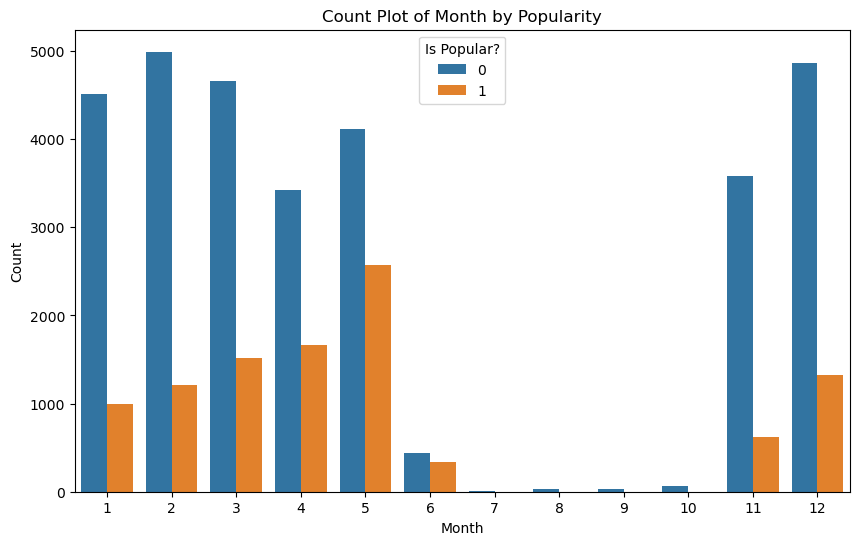

In [19]:
# count plot of `month` by `is_popular`
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='month', hue='is_popular')
plt.title('Count Plot of Month by Popularity')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend(title="Is Popular?", loc='best')
plt.show()

From this plot, we can see that there are few videos in the summer / early fall in this dataset (July - October). This is a result of when the data was scrapped (November to June). However, we can see that there is a slight trend in popularity between the months of the year. On average, it appears that early in the year (January, February, and March) have the most video uploaded. However, it appears that April and May have the highest count of popular videos.

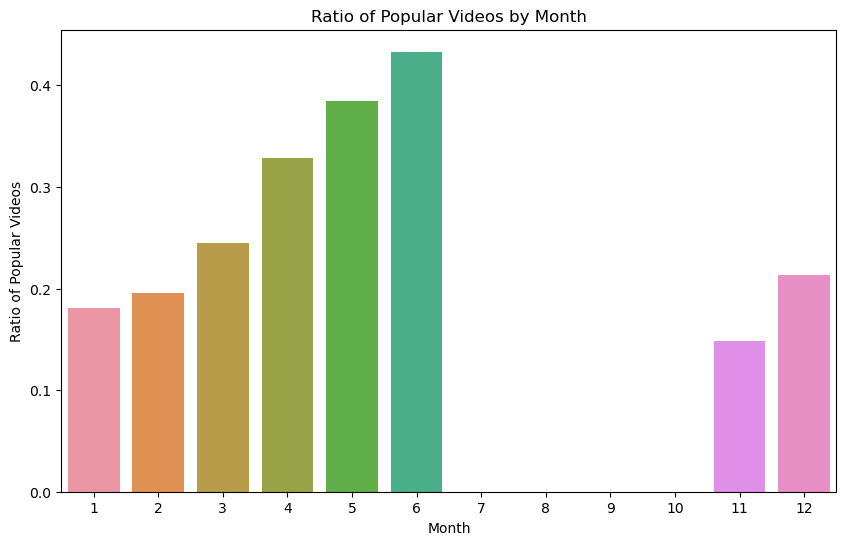

In [20]:
# calculate the ratio of popular videos by month
month_popularity_ratio = df.groupby('month')['is_popular'].mean()

plt.figure(figsize=(10, 6))
sns.barplot(x=month_popularity_ratio.index, y=month_popularity_ratio.values)
plt.title('Ratio of Popular Videos by Month')
plt.xlabel('Month')
plt.ylabel('Ratio of Popular Videos')
plt.show()

Interestingly, early on in the year, (January, February, and March) have the most videos uploaded, however they have the lowest popularity. This may because in a New Year, individuals try to avoid their indulgences (such as watching YouTube videos), but then there is a spike in popularity of videos in the middle of the year. In June, there were a smaller count of videos uploaded however, the popularity of videos was the highest. This could be because of the start of summer and individuals have more free time to watch YouTube videos.

### Is there a certain publish day-of-the-week that shows a trend in popularity?

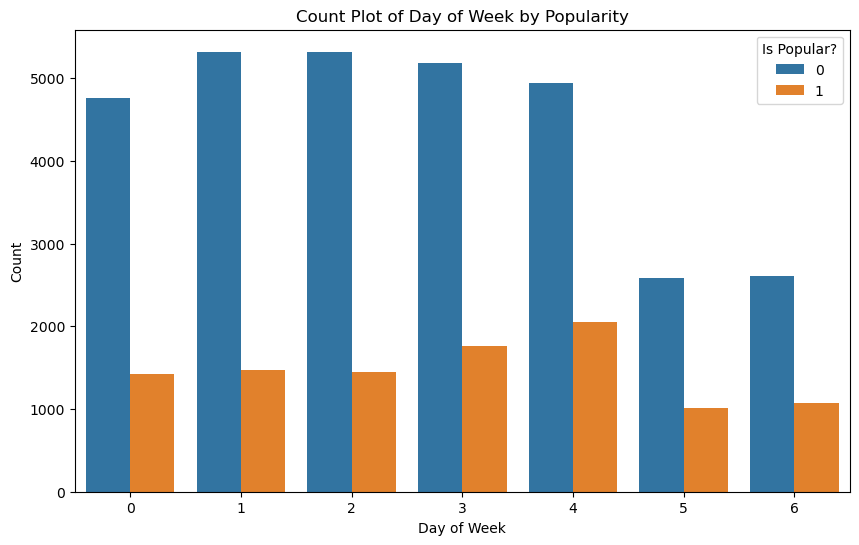

In [21]:
# count plot of `day_of_week` by `is_popular`
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='day_of_week', hue='is_popular')
plt.title('Count Plot of Day of Week by Popularity')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.legend(title="Is Popular?", loc='best')
plt.show()

It appears that most videos are posted on workdays (Monday - Friday), and less videos are posted on the weekends (Saturday - Sunday). 

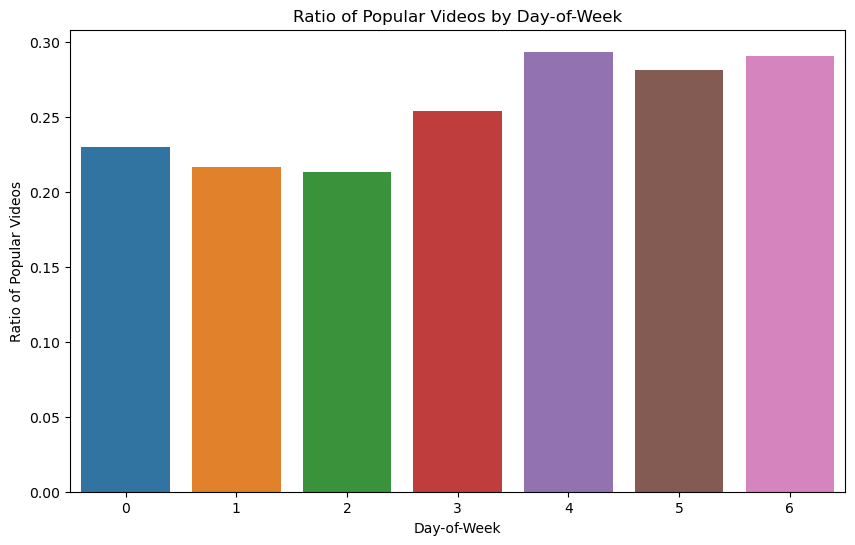

In [22]:
# calculate the ratio of popular videos by day-of-week
day_popularity_ratio = df.groupby('day_of_week')['is_popular'].mean()

plt.figure(figsize=(10, 6))
sns.barplot(x=day_popularity_ratio.index, y=day_popularity_ratio.values)
plt.title('Ratio of Popular Videos by Day-of-Week')
plt.xlabel('Day-of-Week')
plt.ylabel('Ratio of Popular Videos')
plt.show()

There doesn't appear to be a trend in popularity between the days of the week. However, it appears that videos posted on the weekends are more likely to be popular than videos posted on workdays. This could be a result of people having more free time on the weekends to watch YouTube videos.

### Is there a certain publish hour of the day that shows a trend in popularity?

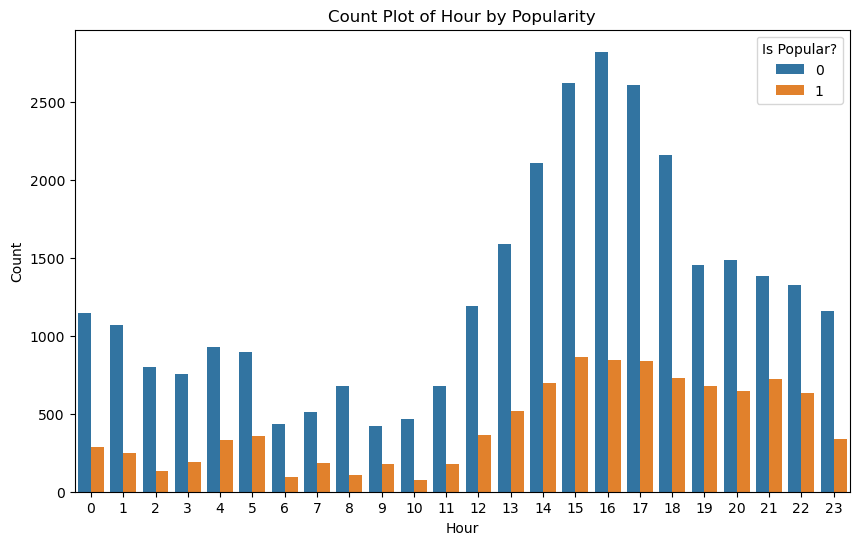

In [23]:
# count plot of `hour` by `is_popular`
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='hour', hue='is_popular')
plt.title('Count Plot of Hour by Popularity')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.legend(title="Is Popular?", loc='best')
plt.show()

It appears that most videos are posted between 1pm - 6pm, and less videos are posted between 6am - 10am. You can also see a decent number of videos posted at 12am - 1am-- this could because channel owners have an automatic upload schedule for their videos. It's a little hard to tell if there is a trend in popularity between the hours of the day, so we can create a hour popularity ratio to see if there is a trend.

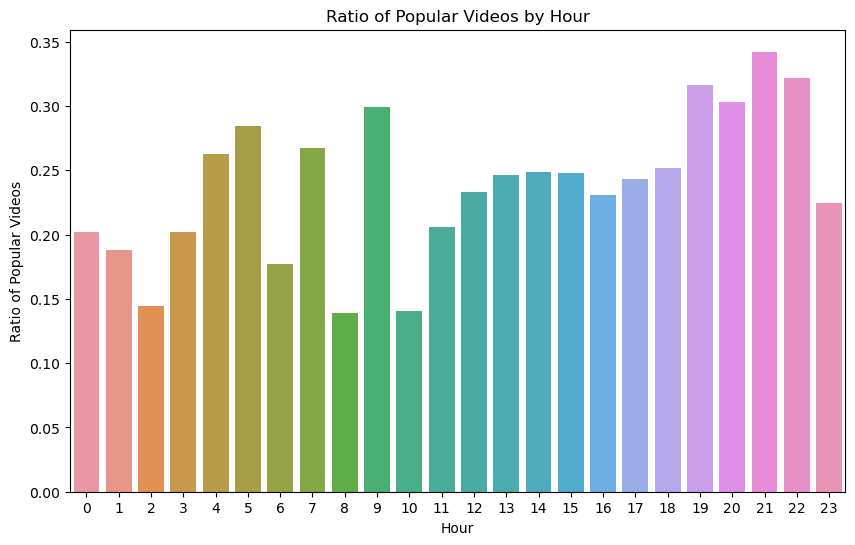

In [24]:
# calculate the ratio of popular videos by hour
hour_popularity_ratio = df.groupby('hour')['is_popular'].mean()

plt.figure(figsize=(10, 6))
sns.barplot(x=hour_popularity_ratio.index, y=hour_popularity_ratio.values)
plt.title('Ratio of Popular Videos by Hour')
plt.xlabel('Hour')
plt.ylabel('Ratio of Popular Videos')
plt.show()

From the above barplot, we can see that the videos posted in the late evening (8pm - 11pm) are more likely to be popular. There is also a sweet spot at 9am where videos posted at this time are more likely to be popular.

## Feature Engineering & Exploratory Data Analysis: `category_id`

Our `category_id` column is an already imputed columns, so for exploratory data analysis, we will have to map the `category_id` to the actual category name. We can then see if there are any trends in popularity between the different categories.

In [25]:
# read in the category names
category_names = pd.read_json('US_category_id.json')

category_names.head()

,kind,etag,items
0,youtube#videoCategoryListResponse,"""m2yskBQFythfE4irbTIeOgYYfBU/S730Ilt-Fi-emsQJv...","{'kind': 'youtube#videoCategory', 'etag': '""m2..."
1,youtube#videoCategoryListResponse,"""m2yskBQFythfE4irbTIeOgYYfBU/S730Ilt-Fi-emsQJv...","{'kind': 'youtube#videoCategory', 'etag': '""m2..."
2,youtube#videoCategoryListResponse,"""m2yskBQFythfE4irbTIeOgYYfBU/S730Ilt-Fi-emsQJv...","{'kind': 'youtube#videoCategory', 'etag': '""m2..."
3,youtube#videoCategoryListResponse,"""m2yskBQFythfE4irbTIeOgYYfBU/S730Ilt-Fi-emsQJv...","{'kind': 'youtube#videoCategory', 'etag': '""m2..."
4,youtube#videoCategoryListResponse,"""m2yskBQFythfE4irbTIeOgYYfBU/S730Ilt-Fi-emsQJv...","{'kind': 'youtube#videoCategory', 'etag': '""m2..."


Our category names are in the `items` column dictionary, so we must extract the category name from the dictionary and map it to the `category_id`.

In [26]:
category_mapping = {}

for item in category_names['items']:
    category_id = int(item['id'])
    category_name = item['snippet']['title']
    category_mapping[category_id] = category_name

category_mapping

{1: 'Film & Animation',
 2: 'Autos & Vehicles',
 10: 'Music',
 15: 'Pets & Animals',
 17: 'Sports',
 18: 'Short Movies',
 19: 'Travel & Events',
 20: 'Gaming',
 21: 'Videoblogging',
 22: 'People & Blogs',
 23: 'Comedy',
 24: 'Entertainment',
 25: 'News & Politics',
 26: 'Howto & Style',
 27: 'Education',
 28: 'Science & Technology',
 29: 'Nonprofits & Activism',
 30: 'Movies',
 31: 'Anime/Animation',
 32: 'Action/Adventure',
 33: 'Classics',
 34: 'Comedy',
 35: 'Documentary',
 36: 'Drama',
 37: 'Family',
 38: 'Foreign',
 39: 'Horror',
 40: 'Sci-Fi/Fantasy',
 41: 'Thriller',
 42: 'Shorts',
 43: 'Shows',
 44: 'Trailers'}

In [27]:
# map the category id to the category name
df['category_name'] = df['category_id'].map(category_mapping)
df.head()

,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,description,log_views,log_likes,log_dislikes,engagement_score_log,engagement_score,is_popular,month,day_of_week,hour,category_name
0,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13 17:13:01+00:00,SHANtell martin,748374,57527,2966,SHANTELL'S CHANNEL - https://www.youtube.com/s...,13.53,10.96,8.00,1.40,0.08,1,11,0,17,People & Blogs
1,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13 07:30:00+00:00,"last week tonight trump presidency|""last week ...",2418783,97185,6146,"One year after the presidential election, John...",14.70,11.48,8.72,1.37,0.04,1,11,0,7,Entertainment
2,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12 19:05:24+00:00,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,14.98,11.89,8.58,1.37,0.05,1,11,6,19,Comedy
3,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13 11:00:04+00:00,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,Today we find out if Link is a Nickelback amat...,12.75,9.23,6.50,1.23,0.03,0,11,0,11,Entertainment
4,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12 18:01:41+00:00,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,I know it's been a while since we did this sho...,14.56,11.79,7.60,1.33,0.06,1,11,6,18,Entertainment


### Is there a certain category that shows a trend in popularity?

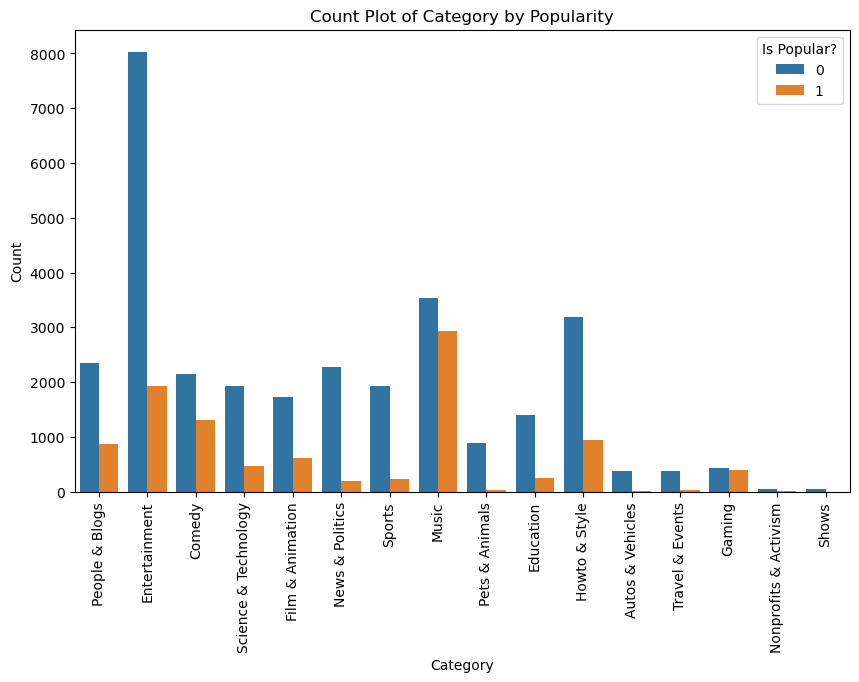

In [28]:
# count plot of `category_name` by `is_popular`
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='category_name', hue='is_popular')
plt.title('Count Plot of Category by Popularity')
plt.xlabel('Category')
# rotate x-axis labels
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.legend(title="Is Popular?", loc='best')

It appears that most videos uploaded fall into the `Entertainment` category, and the least videos uploaded fall into the `Nonprofits & Activism` and `Shows` category.

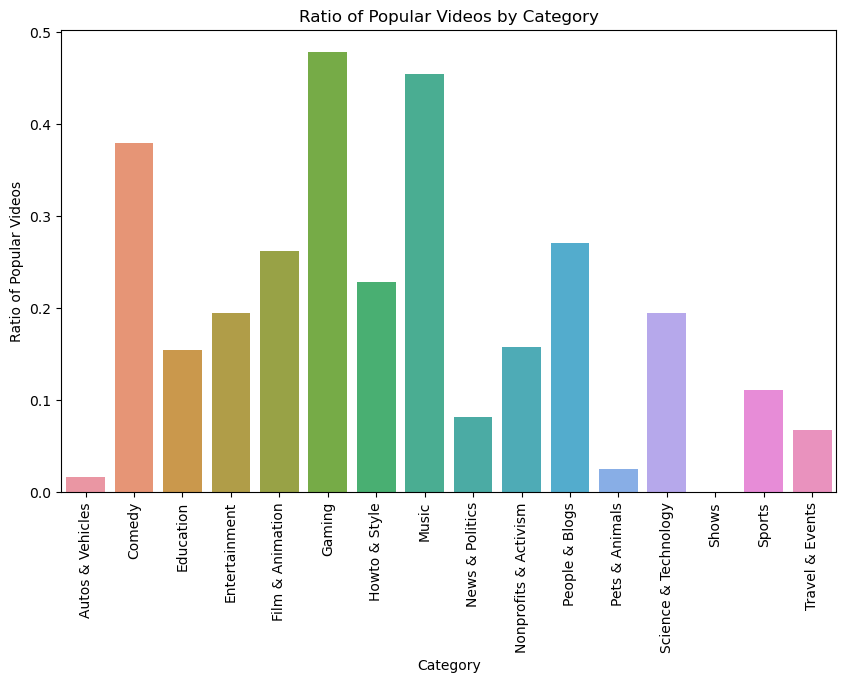

In [29]:
# calculate the ratio of popular videos by category
category_popularity_ratio = df.groupby('category_name')['is_popular'].mean()

plt.figure(figsize=(10, 6))
sns.barplot(x=category_popularity_ratio.index, y=category_popularity_ratio.values)
plt.title('Ratio of Popular Videos by Category')
plt.xlabel('Category')
# rotate x-axis labels
plt.xticks(rotation=90)
plt.ylabel('Ratio of Popular Videos')
plt.show()

Despite most videos being uploaded in the `Entertainment` category, it appears that the `Gaming` category has the highest popularity ratio. `Music` videos also appear to be quite popular and have a high number of videos uploaded.

## Feature Engineering & Exploratory Data Analysis: `title`, `description`, and `tags` Part I

Our `title`, `description`, and `tags` columns are all text columns, so we will have to do some text preprocessing before we can do any exploratory data analysis. We will be using the `nltk` library to help us with our text preprocessing.

First let's take a look at what our text columns look like...

In [30]:
df['title']

0                       WE WANT TO TALK ABOUT OUR MARRIAGE
1        The Trump Presidency: Last Week Tonight with J...
2        Racist Superman | Rudy Mancuso, King Bach & Le...
3                         Nickelback Lyrics: Real or Fake?
4                                 I Dare You: GOING BALD!?
                               ...                        
40944                         The Cat Who Caught the Laser
40945                           True Facts : Ant Mutualism
40946    I GAVE SAFIYA NYGAARD A PERFECT HAIR MAKEOVER ...
40947                  How Black Panther Should Have Ended
40948    Official Call of Duty®: Black Ops 4 — Multipla...
Name: title, Length: 40949, dtype: object

In [31]:
df['description']

0        SHANTELL'S CHANNEL - https://www.youtube.com/s...
1        One year after the presidential election, John...
2        WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3        Today we find out if Link is a Nickelback amat...
4        I know it's been a while since we did this sho...
                               ...                        
40944       The Cat Who Caught the Laser - Aaron's Animals
40945                                                  NaN
40946    I had so much fun transforming Safiyas hair in...
40947    How Black Panther Should Have EndedWatch More ...
40948    Call of Duty: Black Ops 4 Multiplayer raises t...
Name: description, Length: 40949, dtype: object

In [32]:
df['tags']

0                                          SHANtell martin
1        last week tonight trump presidency|"last week ...
2        racist superman|"rudy"|"mancuso"|"king"|"bach"...
3        rhett and link|"gmm"|"good mythical morning"|"...
4        ryan|"higa"|"higatv"|"nigahiga"|"i dare you"|"...
                               ...                        
40944    aarons animals|"aarons"|"animals"|"cat"|"cats"...
40945                                               [none]
40946    I gave safiya nygaard a perfect hair makeover ...
40947    Black Panther|"HISHE"|"Marvel"|"Infinity War"|...
40948        call of duty|"cod"|"activision"|"Black Ops 4"
Name: tags, Length: 40949, dtype: object

It appears that our `title` column is fairly clean, but our `description` and `tags` columns have a lot of HTML tags, special characters, and punctuation. For example, in our `tags` column we have a `|` to divide the tags, we will need to remove and replace these with spaces. To clean our text we will need to remove all of these special characters and punctuation, and then we will need to tokenize our text. Tokenization is the process of splitting a string of text into tokens. We will be using the `word_tokenize` function from the `nltk` library to tokenize our text.

In [33]:
# !!!Note this function has been tailored to the US-YouTube dataset!!!
def clean_text(text):
    if isinstance(text, str):
        # Replace '|' with whitespace
        text = text.replace('|', ' ') # tags are seperated by '|'
        # Normalize Unicode characters
        text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Remove special characters and emojis
        text = re.sub(r'[^\w\s]', '', text)
        # Remove URLs or links
        text = re.sub(r'http\S+|www\S+|bit\.ly\S+', '', text)
        # Convert to lowercase
        text = text.lower()
        # Remove stop words
        text = ' '.join(word for word in text.split() if word not in stopwords_set)
        # Remove 'n n'
        text = re.sub(r'\d+ \d+', '', text)
        text = re.sub(r'n n', '', text)
    else:
        text = ''
    return text

stopwords_set = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to perform lemmatization on text
def lemmatize_text(text):
    if isinstance(text, str):
        # Tokenize the text
        tokens = nltk.word_tokenize(text)
        # Lemmatize each token
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
        # Remove stopwords
        lemmatized_text = ' '.join(token for token in lemmatized_tokens if token not in stopwords_set)
    else:
        lemmatized_text = ''
    return lemmatized_text

In [34]:
# Clean the text in the 'title' column
df['title'] = df['title'].apply(clean_text)

df['title']

0                                       want talk marriage
1        trump presidency last week tonight john oliver...
2         racist superman rudy mancuso king bach lele pons
3                              nickelback lyrics real fake
4                                          dare going bald
                               ...                        
40944                                     cat caught laser
40945                             true facts ant mutualism
40946    gave safiya nygaard perfect hair makeover base...
40947                                  black panther ended
40948    official call duty black ops 4 multiplayer rev...
Name: title, Length: 40949, dtype: object

In [35]:
# Clean the text in the 'description' column
df['description'] = df['description'].apply(clean_text)

df['description']

0        shantells channel video 4k lens drone gear cam...
1        one year presidential election john oliver dis...
2        watch previous video nnsubscribe watching like...
3        today find link nickelback amateur secret nick...
4        know since show back might best episode yetnle...
                               ...                        
40944                      cat caught laser aarons animals
40945                                                     
40946    much fun transforming safiyas hair video servi...
40947    black panther endedwatch hishes hishe thehishe...
40948    call duty black ops 4 multiplayer raises bar f...
Name: description, Length: 40949, dtype: object

In [36]:
# Clean the text in the 'tags' column
df['tags'] = df['tags'].apply(clean_text)

df['tags']

0                                          shantell martin
1        last week tonight trump presidency last week t...
2        racist superman rudy mancuso king bach racist ...
3        rhett link gmm good mythical morning rhett lin...
4        ryan higa higatv nigahiga dare idy rhpc dares ...
                               ...                        
40944    aarons animals aarons animals cat cats kitten ...
40945                                                 none
40946    gave safiya nygaard perfect hair makeover base...
40947    black panther hishe marvel infinity war ended ...
40948                 call duty cod activision black ops 4
Name: tags, Length: 40949, dtype: object

In [37]:
# Apply lemmatization to the 'title' column
df['title'] = df['title'].apply(lemmatize_text)

df['title']

0                                       want talk marriage
1        trump presidency last week tonight john oliver...
2         racist superman rudy mancuso king bach lele pons
3                               nickelback lyric real fake
4                                          dare going bald
                               ...                        
40944                                     cat caught laser
40945                              true fact ant mutualism
40946    gave safiya nygaard perfect hair makeover base...
40947                                  black panther ended
40948    official call duty black ops 4 multiplayer rev...
Name: title, Length: 40949, dtype: object

In [38]:
# Apply lemmatization to the 'description' column
df['description'] = df['description'].apply(lemmatize_text)

df['description']

0        shantells channel video 4k lens drone gear cam...
1        one year presidential election john oliver dis...
2        watch previous video nnsubscribe watching like...
3        today find link nickelback amateur secret nick...
4        know since show back might best episode yetnle...
                               ...                        
40944                        cat caught laser aaron animal
40945                                                     
40946    much fun transforming safiyas hair video servi...
40947    black panther endedwatch hishes hishe thehishe...
40948    call duty black ops 4 multiplayer raise bar fa...
Name: description, Length: 40949, dtype: object

In [39]:
# Apply lemmatization to the 'tags' column
df['tags'] = df['tags'].apply(lemmatize_text)

df['tags']

0                                          shantell martin
1        last week tonight trump presidency last week t...
2        racist superman rudy mancuso king bach racist ...
3        rhett link gmm good mythical morning rhett lin...
4        ryan higa higatv nigahiga dare idy rhpc dare t...
                               ...                        
40944    aaron animal aaron animal cat cat kitten kitte...
40945                                                 none
40946    gave safiya nygaard perfect hair makeover base...
40947    black panther hishe marvel infinity war ended ...
40948                 call duty cod activision black ops 4
Name: tags, Length: 40949, dtype: object

Now that we have tokenized and cleaned our text, we can do some exploratory data analysis on our text columns. Let's take a look at what words are most common in our `title`, `description`, and `tags` columns.

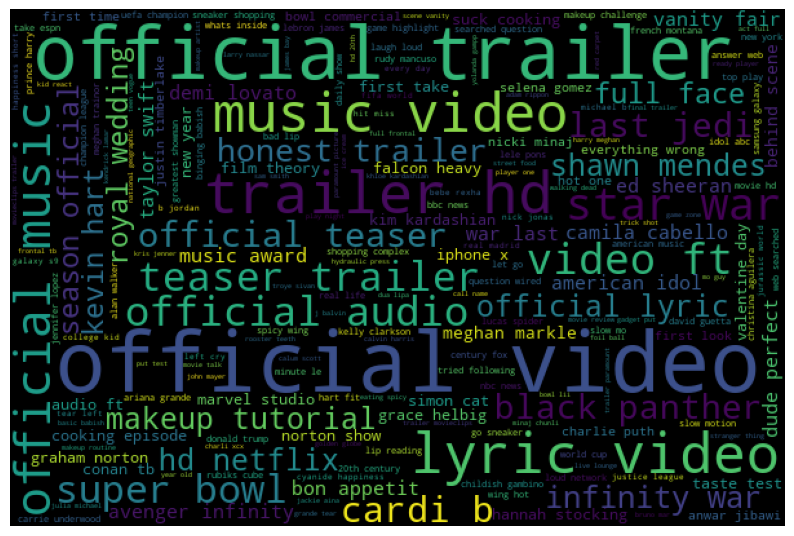

In [40]:
# create a word cloud for the 'title' column
title_wordcloud = WordCloud(width=600, height=400).generate(' '.join(df['title']))

plt.figure(figsize=(10, 8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

For the `title` column, words that follow the word **official** are the most common. Other words related to music are quite popular like **lyric**, **music**, and a plethora of artists. This lines up with our previous analysis of music videos being quite popular (in count of videos uploaded).

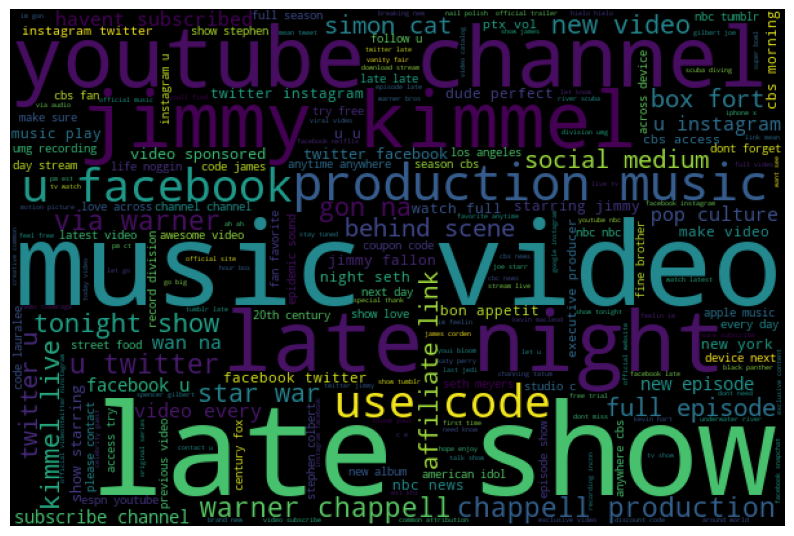

In [41]:
# create a word cloud for the 'description' column
description_wordcloud = WordCloud(width=600, height=400).generate(' '.join(df['description']))

plt.figure(figsize=(10, 8))
plt.imshow(description_wordcloud)
plt.axis('off')
plt.show()

For the `description` column, words related to **late** are quite popular-- it seems like there was a trend with the Jimmy Kimmel late night show that was quite popular. Other words related to music are also quite popular like **music**, **production**, and **pop culture**. 

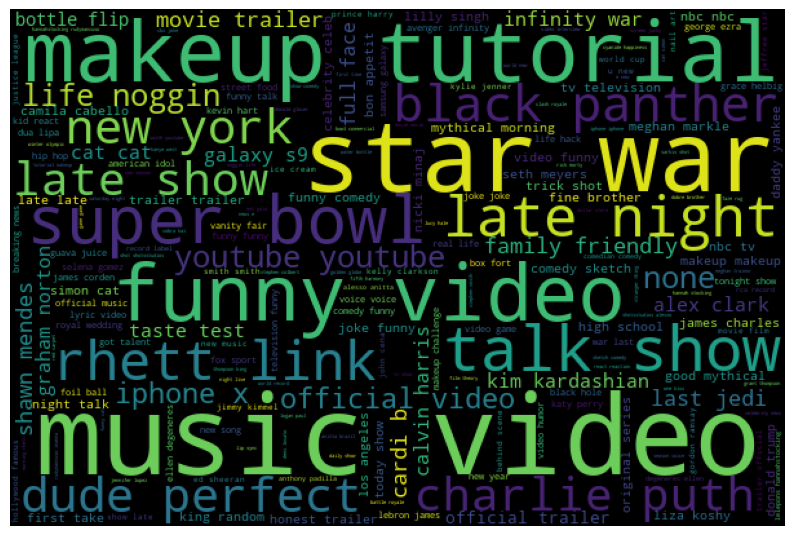

In [42]:
# create a word cloud for the 'tags' column
tags_wordcloud = WordCloud(width=600, height=400).generate(' '.join(df['tags']))

# display the generated wordcloud image
plt.figure(figsize=(10, 8))
plt.imshow(tags_wordcloud)
plt.axis('off')
plt.show()

The most common tags are **music video**, **star war**, **funny video** and **makeup tutorial**.

## Feature Engineering & Exploratory Data Analysis: `title`, `description`, and `tags` Part II

Now that we have cleaned our text, we must do some feature engineering them so they can be usable for our model. We will use the `title`, `description`, and `tags` columns to feature engineer new columns like `title_length`, `description_length`, `tag_count`, `tag_length`, and `tag_popularity`.

In [43]:
# Create a new column `title_length` `description_length` `tags_length` with the length of each video's title, description and tags
df['title_length'] = df['title'].apply(lambda x: len(x))

df['description_length'] = df['description'].apply(lambda x: len(x))

df['tags_length'] = df['tags'].apply(lambda x: len(x))

df.head()

,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,description,log_views,...,engagement_score_log,engagement_score,is_popular,month,day_of_week,hour,category_name,title_length,description_length,tags_length
0,want talk marriage,CaseyNeistat,22,2017-11-13 17:13:01+00:00,shantell martin,748374,57527,2966,shantells channel video 4k lens drone gear cam...,13.53,...,1.40,0.08,1,11,0,17,People & Blogs,18,420,15
1,trump presidency last week tonight john oliver...,LastWeekTonight,24,2017-11-13 07:30:00+00:00,last week tonight trump presidency last week t...,2418783,97185,6146,one year presidential election john oliver dis...,14.70,...,1.37,0.04,1,11,0,7,Entertainment,50,313,96
2,racist superman rudy mancuso king bach lele pons,Rudy Mancuso,23,2017-11-12 19:05:24+00:00,racist superman rudy mancuso king bach racist ...,3191434,146033,5339,watch previous video nnsubscribe watching like...,14.98,...,1.37,0.05,1,11,6,19,Comedy,48,223,261
3,nickelback lyric real fake,Good Mythical Morning,24,2017-11-13 11:00:04+00:00,rhett link gmm good mythical morning rhett lin...,343168,10172,666,today find link nickelback amateur secret nick...,12.75,...,1.23,0.03,0,11,0,11,Entertainment,26,456,399
4,dare going bald,nigahiga,24,2017-11-12 18:01:41+00:00,ryan higa higatv nigahiga dare idy rhpc dare t...,2095731,132235,1989,know since show back might best episode yetnle...,14.56,...,1.33,0.06,1,11,6,18,Entertainment,15,189,83


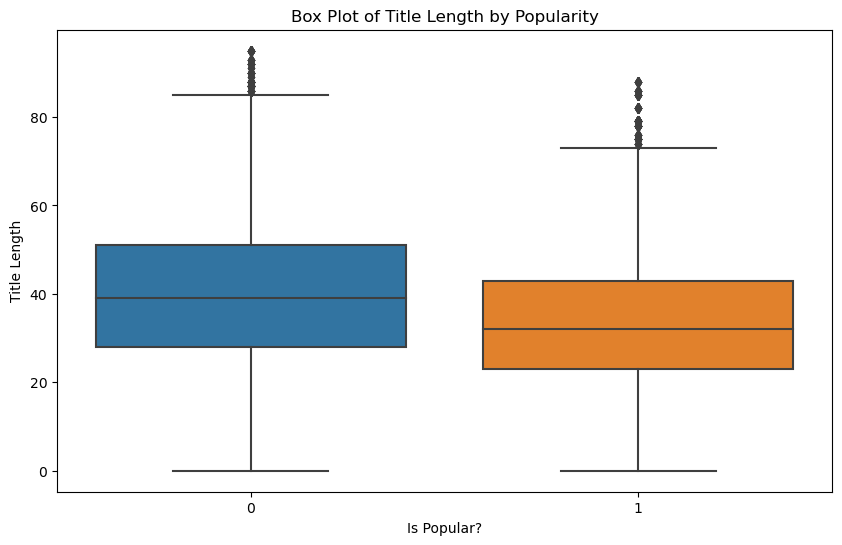

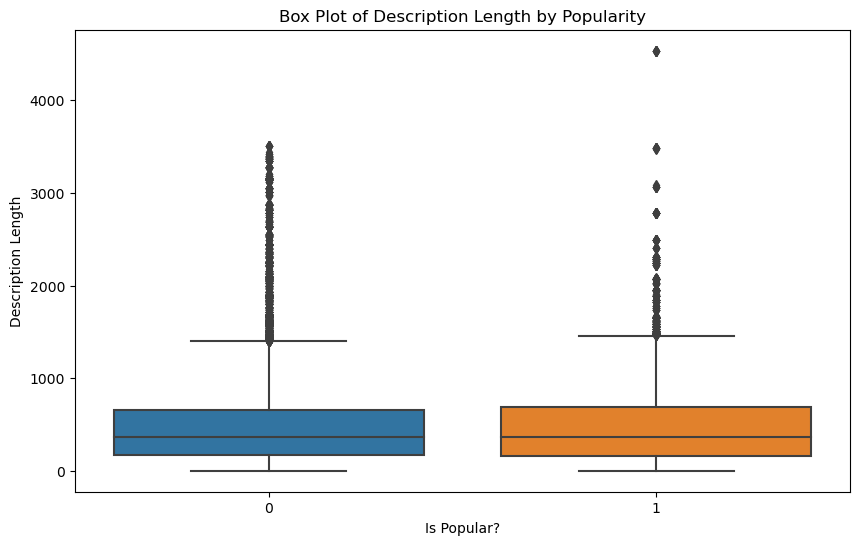

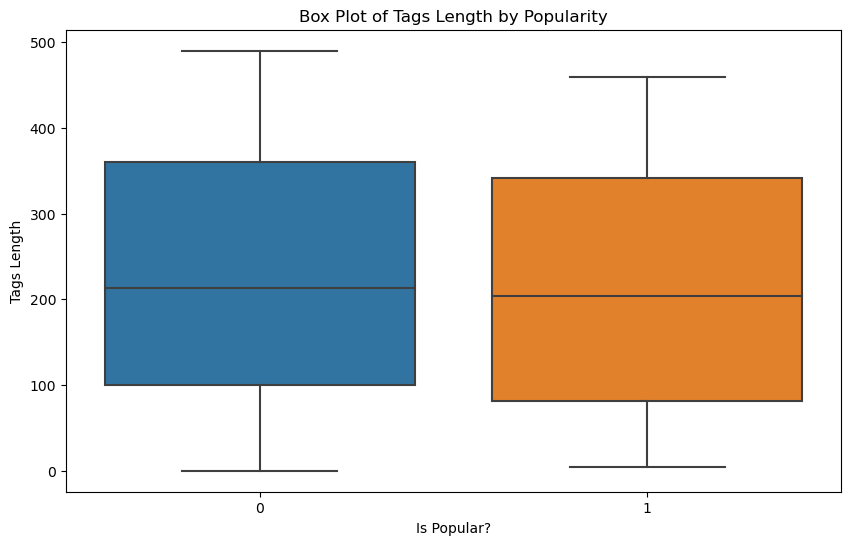

In [44]:
# create plot of `title_length`, `description_length` and `tags_length` by `is_popular`
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='is_popular', y='title_length')
plt.title('Box Plot of Title Length by Popularity')
plt.xlabel('Is Popular?')
plt.ylabel('Title Length')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='is_popular', y='description_length')
plt.title('Box Plot of Description Length by Popularity')
plt.xlabel('Is Popular?')
plt.ylabel('Description Length')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='is_popular', y='tags_length')
plt.title('Box Plot of Tags Length by Popularity')
plt.xlabel('Is Popular?')
plt.ylabel('Tags Length')
plt.show()

There doesn't appear to be a trend in popularity between the length of the title and the popularity of the video.

We want to understand what words are most common in the most popular videos. To do so, let's get the top 100 most popular words in the `title`, `description`, and `tags` columns.

In [45]:
# generator function that will yield the top 100 words based on their counts
def top_words_generator(word_counts, top_word_count=100):
    sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    for word, count in sorted_words[:top_word_count]:
        yield word

In [46]:
top_word_count = 100 # adjust to figure out what is a reasonable number of words analyze


title_text = ' '.join(df[df['is_popular'] == 1]['title'])
description_text = ' '.join(df[df['is_popular'] == 1]['description'])
tags_text = ' '.join(df[df['is_popular'] == 1]['tags'])

# split text into individual words
title_words = title_text.split()
description_words = description_text.split()
tags_words = tags_text.split()

# create a counter of the words
title_counter = Counter(title_words)
description_counter = Counter(description_words)
tags_counter = Counter(tags_words)

In [47]:
# create generator object using the generator function
top_words_title_gen = top_words_generator(title_counter)
top_words_description_gen = top_words_generator(description_counter)
top_words_tags_gen = top_words_generator(tags_counter)

# iterate through the generator to get the top 1000 words
top_words_title = [word for word in top_words_title_gen]
top_words_description = [word for word in top_words_description_gen]
top_words_tags = [word for word in top_words_tags_gen]

print("The top 10 words in the titles of popular videos are: \n{}".format(top_words_title[:10]))
print("\nThe top 10 words in the descriptions of popular videos are: \n{}".format(top_words_description[:10]))
print("\nThe top 10 words in the tags of popular videos are: \n{}".format(top_words_tags[:10]))

The top 10 words in the titles of popular videos are: 
['official', 'video', 'ft', 'trailer', 'music', 'makeup', 'v', '2017', 'challenge', 'audio']

The top 10 words in the descriptions of popular videos are: 
['video', 'music', 'u', 'new', 'channel', 'get', 'like', 'im', 'make', 'twitter']

The top 10 words in the tags of popular videos are: 
['video', 'makeup', 'music', 'new', 'funny', 'challenge', 'movie', 'official', 'youtube', 'tutorial']


Many of the words that were frequently used in videos are among the words in the most popular words. We can iterate over the rows of the dataframe and count the occurences of the top words for `title`, `description`, and `tags` columns, divide them by the count length for each instance and feature engineer the columns `popular_title_words_ratio`, `popular_description_words_ratio`, and `popular_tags_words_ratio`.

In [48]:
def getWordCountRatio(popular_words, text):
    count = 0
    for word in text.split():
        if word in popular_words:
            count += 1

    if len(text.split()) == 0: # avoid division by zero
        return 0
    else:
        return count/len(text.split())

In [49]:
df['popular_title_words_ratio'] = df['title'].apply(lambda x: getWordCountRatio(top_words_title, x))

df['popular_description_words_ratio'] = df['description'].apply(lambda x: getWordCountRatio(top_words_description, x))

df['popular_tags_words_ratio'] = df['tags'].apply(lambda x: getWordCountRatio(top_words_tags, x))  

In [50]:
df.head()

,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,description,log_views,...,month,day_of_week,hour,category_name,title_length,description_length,tags_length,popular_title_words_ratio,popular_description_words_ratio,popular_tags_words_ratio
0,want talk marriage,CaseyNeistat,22,2017-11-13 17:13:01+00:00,shantell martin,748374,57527,2966,shantells channel video 4k lens drone gear cam...,13.53,...,11,0,17,People & Blogs,18,420,15,0.00,0.13,0.00
1,trump presidency last week tonight john oliver...,LastWeekTonight,24,2017-11-13 07:30:00+00:00,last week tonight trump presidency last week t...,2418783,97185,6146,one year presidential election john oliver dis...,14.70,...,11,0,7,Entertainment,50,313,96,0.38,0.17,0.00
2,racist superman rudy mancuso king bach lele pons,Rudy Mancuso,23,2017-11-12 19:05:24+00:00,racist superman rudy mancuso king bach racist ...,3191434,146033,5339,watch previous video nnsubscribe watching like...,14.98,...,11,6,19,Comedy,48,223,261,0.50,0.26,0.22
3,nickelback lyric real fake,Good Mythical Morning,24,2017-11-13 11:00:04+00:00,rhett link gmm good mythical morning rhett lin...,343168,10172,666,today find link nickelback amateur secret nick...,12.75,...,11,0,11,Entertainment,26,456,399,0.50,0.28,0.21
4,dare going bald,nigahiga,24,2017-11-12 18:01:41+00:00,ryan higa higatv nigahiga dare idy rhpc dare t...,2095731,132235,1989,know since show back might best episode yetnle...,14.56,...,11,6,18,Entertainment,15,189,83,0.00,0.40,0.14


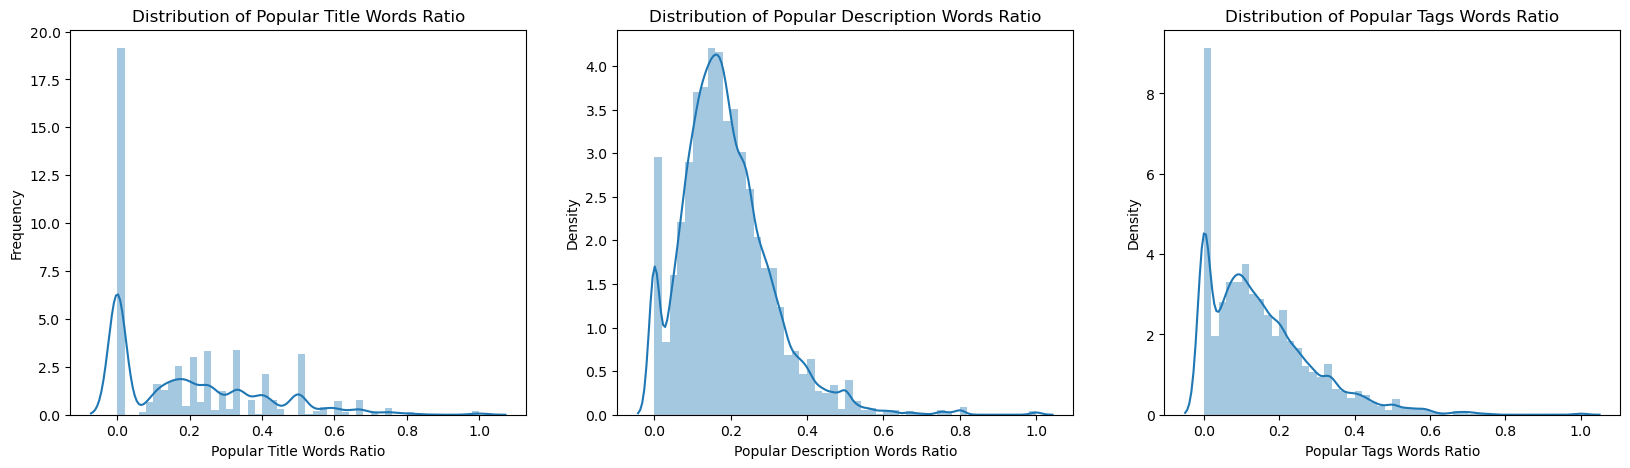

In [51]:
plt.figure(figsize=(20, 5))

# popular_title_words_ratio
plt.subplot(1, 3, 1)
sns.distplot(df['popular_title_words_ratio'])
plt.title('Distribution of Popular Title Words Ratio')
plt.xlabel('Popular Title Words Ratio')
plt.ylabel('Frequency')

# popular_description_words_ratio
plt.subplot(1, 3, 2)
sns.distplot(df['popular_description_words_ratio'])
plt.title('Distribution of Popular Description Words Ratio')
plt.xlabel('Popular Description Words Ratio')

# popular_tags_words_ratio
plt.subplot(1, 3, 3)
sns.distplot(df['popular_tags_words_ratio'])
plt.title('Distribution of Popular Tags Words Ratio')
plt.xlabel('Popular Tags Words Ratio')

plt.show()


The distribution of the `popular_<text>_ratio` columns are all heavily skewed right. This is unsurprising, as the 75% of the videos are classified as not popular. 

## Prepare for Modeling
Now that we have feature engineered columns based on our `publish_time` and text columns, we are ready to get the data ready for modeling. Before we create our model, we first have to choose our input features. Not all of the columns we currently have in our `df` are necessary for our model, but instead we can use our feature engineered columns instead.

In [52]:
df.columns

Index(['title', 'channel_title', 'category_id', 'publish_time', 'tags',
       'views', 'likes', 'dislikes', 'description', 'log_views', 'log_likes',
       'log_dislikes', 'engagement_score_log', 'engagement_score',
       'is_popular', 'month', 'day_of_week', 'hour', 'category_name',
       'title_length', 'description_length', 'tags_length',
       'popular_title_words_ratio', 'popular_description_words_ratio',
       'popular_tags_words_ratio'],
      dtype='object')

In [53]:
# remove the columns that are no longer needed
columns_to_drop = ['title', 'channel_title', 'publish_time', 'tags', 'views', 'likes', 'dislikes', 'description',
                   'log_views', 'log_likes', 'log_dislikes', 'engagement_score_log', 'engagement_score', 'category_name']

df.drop(columns_to_drop, inplace=True, axis=1)

df.head()

,category_id,is_popular,month,day_of_week,hour,title_length,description_length,tags_length,popular_title_words_ratio,popular_description_words_ratio,popular_tags_words_ratio
0,22,1,11,0,17,18,420,15,0.00,0.13,0.00
1,24,1,11,0,7,50,313,96,0.38,0.17,0.00
2,23,1,11,6,19,48,223,261,0.50,0.26,0.22
3,24,0,11,0,11,26,456,399,0.50,0.28,0.21
4,24,1,11,6,18,15,189,83,0.00,0.40,0.14


This now leaves us with our feature engineered columns. Note how we removed the `likes`, `dislikes`, and `views` columns as well as the feature engineered `engagement_score` columns as these columns are not available at the time of publishing a video. To predict whether or not a video will be popular, we want to use only the features that are available at the time of a content creator posting their video.

### Splitting the Data into Training and Testing Sets
To model our data, we will set our `is_popular` column as our target variable, and the rest of our columns as our input features. We will then split our data into training (80%) and testing sets (20%).

In [54]:
X = df.drop('is_popular', axis=1)
y = df['is_popular']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32759, 10), (8190, 10), (32759,), (8190,))

### Creating Modeling and Evaluation Functions
Because we will be reperforming the same steps for each model, we can create functions to fit and score them. We will also create a functions to create plots and reports for evalution.

In [55]:
def train_fit_eval(model, X_train, y_train, X_test, y_test):
    '''
    Function to train, fit and evaluate a model.
    '''
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    accuracy_train = accuracy_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred)
    recall_train = recall_score(y_train, y_train_pred)
    f1_train = f1_score(y_train, y_train_pred)

    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    f1_test = f1_score(y_test, y_test_pred)

    table = PrettyTable()
    table.field_names = ["Metric", "Train Score", "Test Score"]
    table.add_row(["Accuracy", accuracy_train, accuracy_test])
    table.add_row(["Precision", precision_train, precision_test])
    table.add_row(["Recall", recall_train, recall_test])
    table.add_row(["F1 Score", f1_train, f1_test])

    print(table)

The `train_fit_eval` function will train, fit and evaluate a model given its name, the training and testing sets, and the input features and target variable. The function will return the model, the predictions, and the classification report. Note how we include the metrics **Precision**, **Recall**, and **F1-Score**. This is because our target variable in imbalanced and the **Accuracy** metric will not be a good indicator of how well our model generalizes to unseen data.

In [56]:
def run_gridsearch(model, param_grid, X_train, y_train):
    """
    Function to perform GridSearchCV for hyperparameter tuning and evaluate the model.
    """
    # perform GridSearchCV and fit the model
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
    grid_search.fit(X_train, y_train)

    # obtain the best model and its hyperparameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    return best_model, best_params

The `run_gridsearch` function will perform a grid search on a model given its name, the training sets' input features and target variable, and the hyperparameters to tune. The function will return the best model and the best parameters.

In [57]:
def plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred, model):
    '''
    Function to plot the ROC curves for train and test sets.
    '''
    # calculate fpr, tpr, and thresholds for train and test sets
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred)
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred)

    # calculate AUC scores for train and test sets
    auc_score_train = auc(fpr_train, tpr_train)
    auc_score_test = auc(fpr_test, tpr_test)

    # plot ROC curves
    plt.plot(fpr_train, tpr_train, color='orange', label='Train ROC curve (AUC = %0.2f)' % auc_score_train)
    plt.plot(fpr_test, tpr_test, color='green', label='Test ROC curve (AUC = %0.2f)' % auc_score_test)
    plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('Receiver Operating Characteristic (ROC) Curve for {}'.format(model))
    plt.legend()
    plt.show()



The ROC curve is a plot that shows the tradeoff between the true positive rate (sensitivity) and the false positive rate. It helps assess the performance of a predictive model using different probability thresholds. The TPR represents the proportion of correctly classified positive observations, while the FPR represents the proportion of incorrectly classified negative observations. By analyzing the ROC curve, we can understand the model's ability to discriminate between positive and negative cases. It is a useful tool for comparing the predictive power of different models and understanding their performance on the same dataset.

In [58]:
def plot_confusion_matrix(y_train, y_train_pred, y_test, y_test_pred, model):
    '''
    Function to plot the confusion matrix.
    '''
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    # get confusion matrix for train set
    cm_train = confusion_matrix(y_train, y_train_pred)
    # plot
    sns.heatmap(cm_train, annot=True, fmt='g', cmap='Blues', ax=axes[0])
    axes[0].set_title('Train Set Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    # get confusion matrix for test set
    cm_test = confusion_matrix(y_test, y_test_pred)
    # plot 
    sns.heatmap(cm_test, annot=True, fmt='g', cmap='Blues', ax=axes[1])
    axes[1].set_title('Test Set Confusion Matrix')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

A confusion matrix is a table that summarizes the performance of a classification model. It shows the counts of true positive (TP), true negative (TN), false positive (FP), and false negative (FN) predictions. The matrix provides insights into the model's accuracy, precision, recall, and F1 score. It helps evaluate the model's ability to correctly classify positive and negative instances. The confusion matrix allows for a comprehensive assessment of the model's performance and aids in understanding the balance between different types of prediction errors.

## Modeling Part I: Baseline Models
We will be using the following models to predict whether or not a video will be popular:
- Logistic Regression
- Random Forest
- K-Nearest Neighbors
- Naive Bayes


### Logistic Regression Baseline
Logistic Regression is a classification algorithm that uses a sigmoid function to predict the probability of a binary outcome. It is a linear model that uses a logistic function to model a binary dependent variable. It is a simple and fast algorithm that performs well on linearly separable classes. It is also easy to implement and interpret.

+-----------+---------------------+--------------------+
|   Metric  |     Train Score     |     Test Score     |
+-----------+---------------------+--------------------+
|  Accuracy |  0.7540217955371044 | 0.7526251526251526 |
| Precision |  0.5237752161383286 | 0.5153631284916201 |
|   Recall  | 0.17753357753357754 |   0.18017578125    |
|  F1 Score |  0.2651832938172533 | 0.2670043415340087 |
+-----------+---------------------+--------------------+


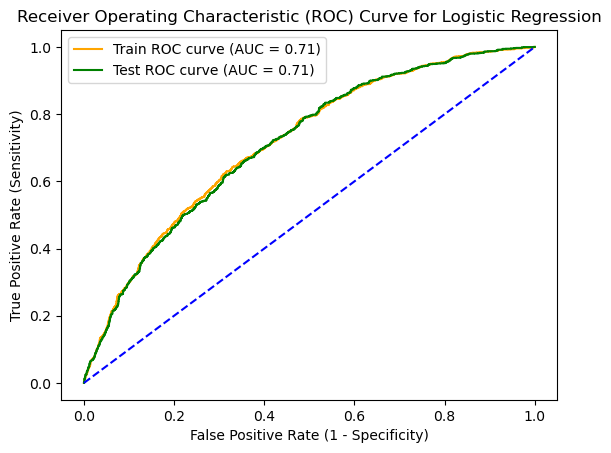

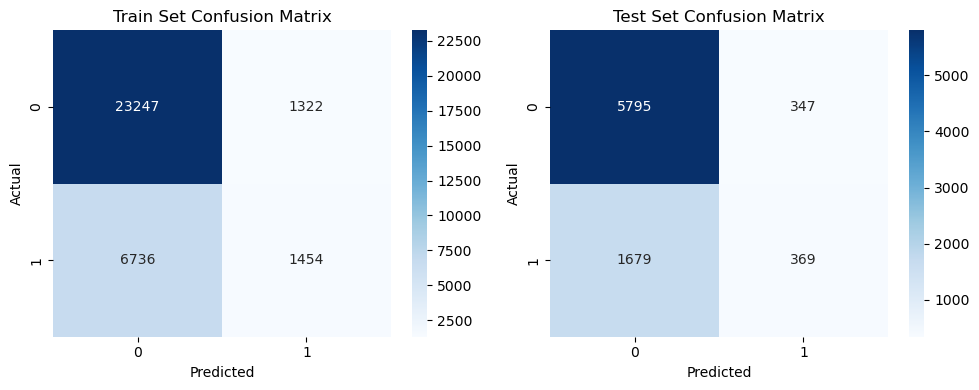

In [59]:
# instantiate a logistic regression model
lr = LogisticRegression(random_state=42)

# train, fit and evaluate the model
train_fit_eval(lr, X_train, y_train, X_test, y_test)

# plot the roc curve
plot_roc_curve(y_train, lr.predict_proba(X_train)[:,1], y_test, lr.predict_proba(X_test)[:, 1], 'Logistic Regression')

# plot the confusion matrix
plot_confusion_matrix(y_train, lr.predict(X_train), y_test, lr.predict(X_test), 'Logistic Regression')

#### Logistic Regression Baseline Model Performance:
* The **accuracy** for both the training and test sets were around **75%**, which is decent score. 
* However, the **precision** for both training and testing data set is around **52%** -- which is not much better than flipping a coin. Because we are interested in identifying popular videos accurately and minimizing the false postives, precision is the most important metric for us.
* The **recall** for both training and testing data sets is around **17%**, which means that it did not do well at correctly predicting popular videos out of all the popular videos.
* The **F1-Score** for both training and testing data sets is around **26%**.

In summary, the Logistic Regression Baseline Model leaves much to be desired because of the low precision and recall scores.

### Random Forest Classifier
Random Forest Classifier is a classification algorithm that uses an ensemble of decision trees to predict the class of a data point. It uses bagging and feature randomness when building each individual tree and then makes a prediction by averaging the predictions of each component tree. It is a powerful algorithm that is robust to outliers.

+-----------+--------------------+--------------------+
|   Metric  |    Train Score     |     Test Score     |
+-----------+--------------------+--------------------+
|  Accuracy | 0.9899874843554443 | 0.9821733821733821 |
| Precision |  0.97327233325307  | 0.9576515880654476 |
|   Recall  | 0.9870573870573871 |    0.9716796875    |
|  F1 Score | 0.9801163918525703 | 0.9646146388754241 |
+-----------+--------------------+--------------------+


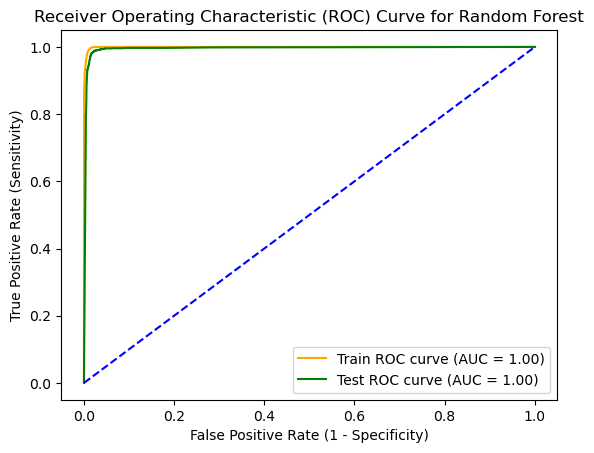

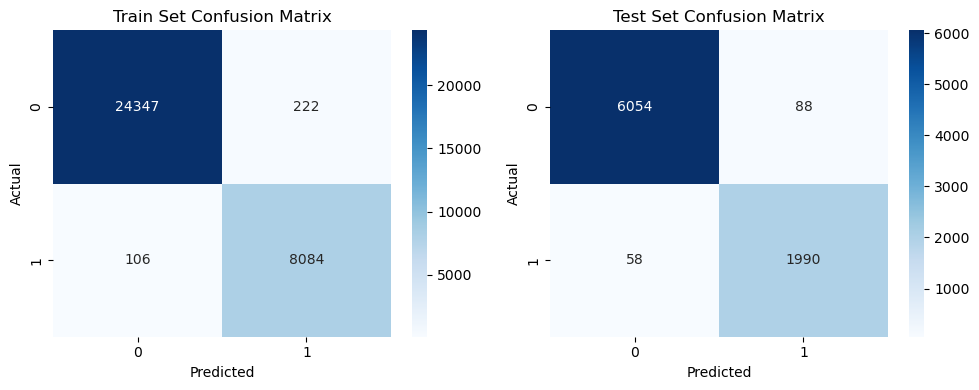

In [60]:
rf = RandomForestClassifier(random_state=42)

# train, fit and evaluate the model
train_fit_eval(rf, X_train, y_train, X_test, y_test)

# plot the roc curve
plot_roc_curve(y_train, rf.predict_proba(X_train)[:,1], y_test, rf.predict_proba(X_test)[:, 1], 'Random Forest')

# plot the confusion matrix
plot_confusion_matrix(y_train, rf.predict(X_train), y_test, rf.predict(X_test), 'Random Forest')

#### Random Forest Classifier Baseline Model Performance:
* The **AUC score** of **1.00** indicates that he model has a perfect measure of separability. This high level of accuracy is likely due to overfitting.
* The model had an **accuracy** of **~99%** on the training set and **~98%** on the testing set, which is a very high score. Again this is a sign of overfitting.
* **Precision** for the training set is around **97%** and **95%** for the test data. This is a type of score we would like to see for our model, however we must be wary of overfitting.
* The **recall** for the training set is around **98%** and **97%** for the test data. This means that the model did well at correctly predicting popular videos out of all the popular videos.
** The **F1-Score** for the training set is around **98%** and **96%** for the test data. This is a good score, but again we must be wary of overfitting.

In summary, our Random Forest Classifier Baseline perfomed extremely well on the training and testing sets. However, since we had a perfect AUC score and almost perfect classification scores on the training set, we must conclude we are overfitting. We will have to tune our hyperparameters to reduce overfitting.

### K-Nearst Neighbors Baseline Model
K-Nearest Neighor is a classification algorithm that uses the distance between a query point and the points in the training set to find the k closest points. It then classifies the query point by taking the majority vote of its k nearest neighbors. It is a simple algorithm that is easy to implement and understand.

+-----------+--------------------+--------------------+
|   Metric  |    Train Score     |     Test Score     |
+-----------+--------------------+--------------------+
|  Accuracy | 0.9726182117891267 | 0.9478632478632478 |
| Precision | 0.9329217618425739 | 0.8761020881670534 |
|   Recall  | 0.9594627594627595 |      0.921875      |
|  F1 Score | 0.9460061397700597 | 0.8984059005472281 |
+-----------+--------------------+--------------------+


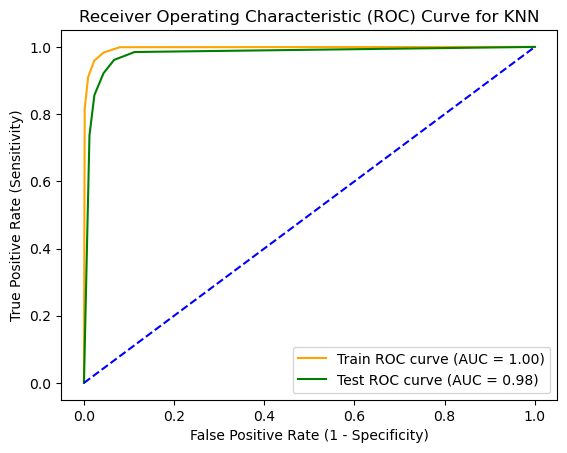

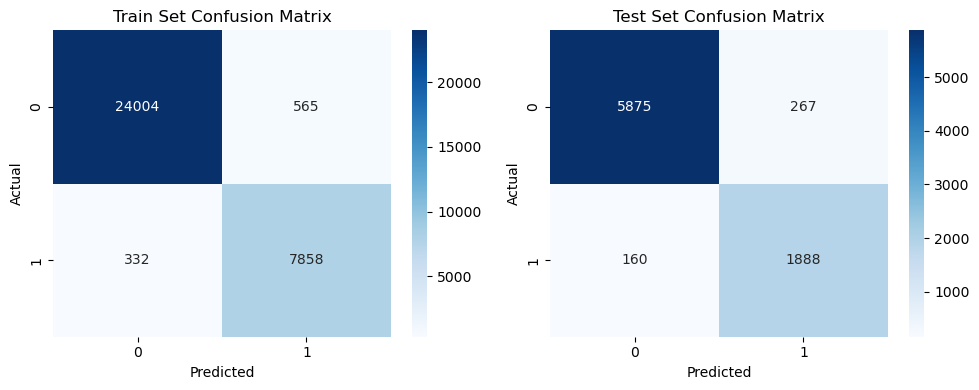

In [61]:
knn = KNeighborsClassifier()

# train, fit and evaluate the model
train_fit_eval(knn, X_train, y_train, X_test, y_test)

# plot the roc curve
plot_roc_curve(y_train, knn.predict_proba(X_train)[:,1], y_test, knn.predict_proba(X_test)[:, 1], 'KNN')

# plot the confusion matrix
plot_confusion_matrix(y_train, knn.predict(X_train), y_test, knn.predict(X_test), 'KNN')

#### K-Nearest Neighbors Baseline Model Performance:
* The training set has an **AUC score** of **100%** and the test set has an AUC score of **99%** which indicates that the model has a perfect measure of separability.
* The **accuracy** of the training set is **97%** and the test set is **95%** which means that the model correctly predicts whether a video of popular or not for a significant amount of the data. With this high level of accuracy, we must be wary of overfitting.
* **Precision** of the training set is **93%** and the test set is **88%** which means that the model correctly predicted positive instances out all instances that were predicted to be positive. This is a good score, but again we must be wary of overfitting.
* The **recall** of the training set is **96%** and the test set is **92%**. 
* The **F1-Score** of the training set is **95%** and the test set is **90%**.

In summary, the KNN model performed very well in precision and F1-Score, however since the training dataset had a high level of accuracy, we must be wary of overfitting.


### Naive Bayes Baseline Model
Naive Bayes is a classification algorithm that uses Bayes' Theorem to predict the probability of a class given a set of features. It assumes that the features are independent of each other. It is a simple algorithm that is easy to implement and works well with high dimensional data.

+-----------+---------------------+--------------------+
|   Metric  |     Train Score     |     Test Score     |
+-----------+---------------------+--------------------+
|  Accuracy |  0.7563722946365884 | 0.7507936507936508 |
| Precision |  0.519456339601564  | 0.5025983667409057 |
|   Recall  | 0.34065934065934067 |   0.33056640625    |
|  F1 Score |  0.4114740800825898 | 0.3988217967599411 |
+-----------+---------------------+--------------------+


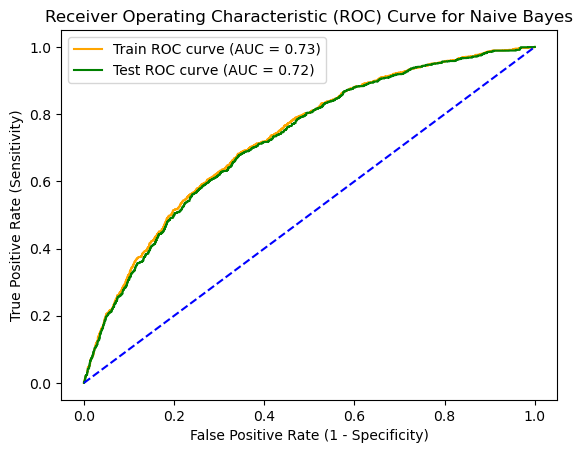

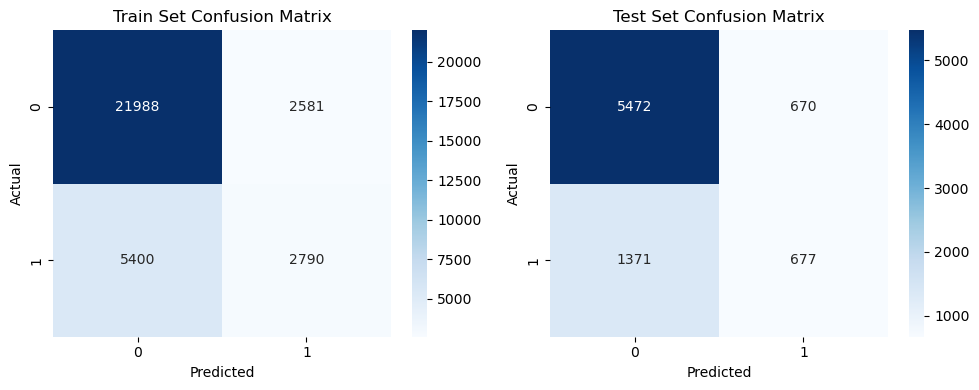

In [62]:
nb = GaussianNB()

# train, fit and evaluate the model
train_fit_eval(nb, X_train, y_train, X_test, y_test)

# plot the roc curve
plot_roc_curve(y_train, nb.predict_proba(X_train)[:,1], y_test, nb.predict_proba(X_test)[:, 1], 'Naive Bayes')

# plot the confusion matrix
plot_confusion_matrix(y_train, nb.predict(X_train), y_test, nb.predict(X_test), 'Naive Bayes')

#### Naive Bayes Baseline Model Performance:
* The **AUC score** of **0.73** and **0.72** for the training and test sets respectively indicates that the model has a good measure of separability. It shows reasonable ability to distinguish between positive and negative classes.
* The model achieved an **accuracy** of **~76%** on the training set and **~75%** on the test set, which is a decent score.
* **Precision** for the training set is around **52%** and **50%** for the test data. This score is not much better than flipping a coin, showing this is not a good model for predicting popular videos.
* The **recall** for the training set is around **34%** and **33%*** for the test set. This means that the model did not do well at measuring the proportion of correctly classified positive observations.
* The **F1 score** for the training set is around **41%** and **40%** for the test set. This is a low score, showing that the model is not good at predicting popular videos.

In summary, the Naive Bayes model performs only okay at predicting whether or a video will be popular or not. This is because of the relatively low precision, recall and F1 scores, which suggests that there is room for improvement.

## Modeling Part II: Hyperparameter Tuning

Now that we have evaluated our baseline models, we can perform hyperparameter tuning to improve the performance of our models. We will be using GridSearchCV to find the best hyperparameters for each model.

### Logistic Regression Hyperparameter Tuning
The hyperparameters we will be tuning are:
- **C**: Inverse of regularization strength. Smaller values specify stronger regularization.
- **penalty**: Used to specify the norm used in the penalization. The ‘newton-cg’, ‘sag’ and ‘lbfgs’ solvers support only l2 penalties.
- **max_iter**: Maximum number of iterations taken for the solvers to converge.

/home/sfirestone/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sfirestone/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

Grid search execution took: 15.727036714553833  seconds
Best parameters: {'C': 10, 'max_iter': 500, 'penalty': 'l2'}
+-----------+---------------------+---------------------+
|   Metric  |     Train Score     |      Test Score     |
+-----------+---------------------+---------------------+
|  Accuracy |  0.7610122409108947 |  0.7592185592185592 |
| Precision |  0.5697719366061075 |  0.5595611285266457 |
|   Recall  | 0.17997557997557997 |    0.17431640625    |
|  F1 Score |  0.2735455135937645 | 0.26582278481012656 |
+-----------+---------------------+---------------------+


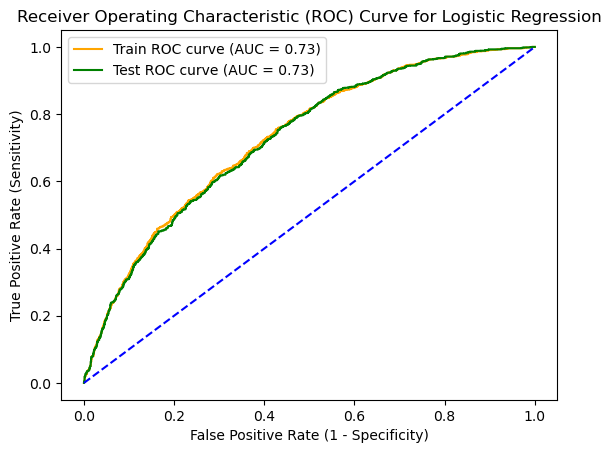

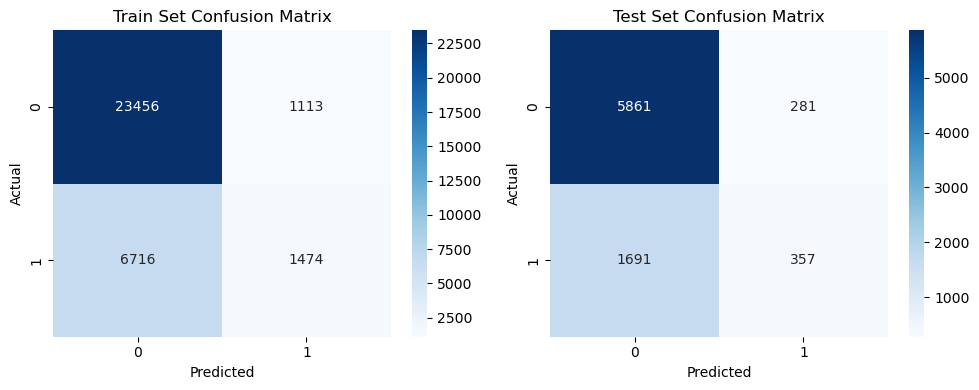

In [63]:
# define the grid of hyperparameters
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10],
    'max_iter': [100, 200, 500]
}

# instantiate a logistic regression model
lr = LogisticRegression(random_state=42)

start_time = time.time() # start timer
# perform grid search
best_lr, best_params_lr = run_gridsearch(lr, param_grid, X_train, y_train)
end_time = time.time() # end timer

# print time taken for grid search
print("Grid search execution took:", str(end_time - start_time), " seconds")
# print best parameters
print("Best parameters:", best_params_lr)

# train, fit and evaluate the model
train_fit_eval(best_lr, X_train, y_train, X_test, y_test)

# plot the roc curve
plot_roc_curve(y_train, best_lr.predict_proba(X_train)[:,1], y_test, best_lr.predict_proba(X_test)[:, 1], 'Logistic Regression')

# plot the confusion matrix
plot_confusion_matrix(y_train, best_lr.predict(X_train), y_test, best_lr.predict(X_test), 'Logistic Regression')


#### Logistic Regression Hyperparameter Tuning Results:
The grid search results for the Logistic Regression model show slight improvements compared to the baseline model; it's precision and F1 score improved by ~5%.

### Random Forest Classifier Hyperparameter Tuning
The hyperparameters we will be tuning are:
- **n_estimators**: The number of trees in the forest.
- **max_depth**: The maximum depth of the tree.
- **min_samples_split**: The minimum number of samples required to split an internal node.
- **min_samples_leaf**: The minimum number of samples required to be at a leaf node.
- **max_features**: The number of features to consider when looking for the best split.

**The below code block is commented out because it takes a long time to run. >> 8 hours :)** 

In [64]:
'''
# define the grid of hyperparameters
params_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# instantiate a random forest model
rf = RandomForestClassifier(random_state=42)

start_time = time.time() # start timer
# perform grid search
best_rf, best_params_rf = run_gridsearch(rf, params_grid, X_train, y_train)
end_time = time.time() # end timer

# print time taken for grid search
print("Grid search execution took:", str(end_time - start_time), " seconds")
# print best parameters
print("Best parameters:", best_params_rf)

# train, fit and evaluate the model
train_fit_eval(best_rf, X_train, y_train, X_test, y_test)

# plot the roc curve
plot_roc_curve(y_train, best_rf.predict_proba(X_train)[:,1], y_test, best_rf.predict_proba(X_test)[:, 1], 'Random Forest')

# plot the confusion matrix
plot_confusion_matrix(y_train, best_rf.predict(X_train), y_test, best_rf.predict(X_test), 'Random Forest')
'''

'\n# define the grid of hyperparameters\nparams_grid = {\n    \'n_estimators\': [100, 200, 300],\n    \'max_depth\': [None, 5, 10],\n    \'min_samples_split\': [2, 5, 10],\n    \'min_samples_leaf\': [1, 2, 4],\n    \'max_features\': [\'auto\', \'sqrt\', \'log2\']\n}\n\n# instantiate a random forest model\nrf = RandomForestClassifier(random_state=42)\n\nstart_time = time.time() # start timer\n# perform grid search\nbest_rf, best_params_rf = run_gridsearch(rf, params_grid, X_train, y_train)\nend_time = time.time() # end timer\n\n# print time taken for grid search\nprint("Grid search execution took:", str(end_time - start_time), " seconds")\n# print best parameters\nprint("Best parameters:", best_params_rf)\n\n# train, fit and evaluate the model\ntrain_fit_eval(best_rf, X_train, y_train, X_test, y_test)\n\n# plot the roc curve\nplot_roc_curve(y_train, best_rf.predict_proba(X_train)[:,1], y_test, best_rf.predict_proba(X_test)[:, 1], \'Random Forest\')\n\n# plot the confusion matrix\nplot_c

#### Random Forest Classifier Hyperparameter Tuning Results:
The Random Forest Classifier did not improve much after hyperparameter tuning. All of the scores were < 1% better than the baseline model.

### K-Nearest Neighbors Hyperparameter Tuning
The hyperparameters we will be tuning are:
- **n_neighbors**: Number of neighbors to use by default for kneighbors queries.
- **weights**: Weight function used in prediction. Possible values: ‘uniform’ or ‘distance’.
- **algorithm**: Algorithm used to compute the nearest neighbors. Possible values: ‘ball_tree’, ‘kd_tree’, ‘brute’.

Grid search execution took: 10.10045599937439  seconds
Best parameters: {'algorithm': 'ball_tree', 'n_neighbors': 7, 'weights': 'distance'}
+-----------+--------------------+--------------------+
|   Metric  |    Train Score     |     Test Score     |
+-----------+--------------------+--------------------+
|  Accuracy | 0.9898653805061205 | 0.9750915750915751 |
| Precision | 0.9748610103940053 | 0.9361400189214759 |
|   Recall  | 0.9848595848595849 |   0.96630859375    |
|  F1 Score | 0.9798347910592808 | 0.9509851033157136 |
+-----------+--------------------+--------------------+


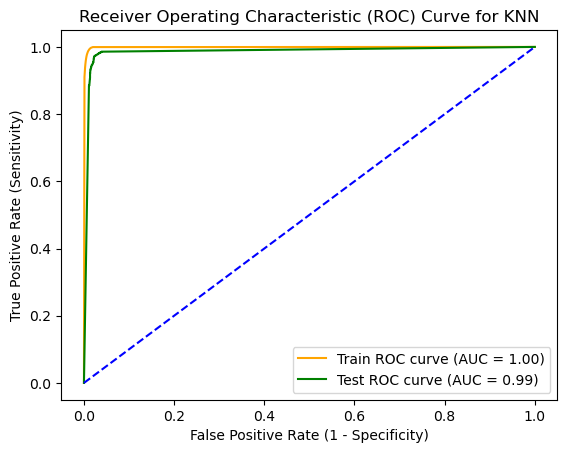

In [65]:
params_grid = {
    'n_neighbors': [3, 5, 7], # should be odd to avoid ties; smaller values reduce variance but increase bias
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute']
}

# instantiate a knn model
knn = KNeighborsClassifier()

start_time = time.time() # start timer
# perform grid search
best_knn, best_params_knn = run_gridsearch(knn, params_grid, X_train, y_train)
end_time = time.time() # end timer

# print time taken for grid search
print("Grid search execution took:", str(end_time - start_time), " seconds")
# print best parameters
print("Best parameters:", best_params_knn)

# train, fit and evaluate the model
train_fit_eval(best_knn, X_train, y_train, X_test, y_test)

# plot the roc curve
plot_roc_curve(y_train, best_knn.predict_proba(X_train)[:,1], y_test, best_knn.predict_proba(X_test)[:, 1], 'KNN')

#### K-Nearest Neighbors Hyperparameter Tuning Results:
The KNN model after hyperparameter tuning greatly improved the KNN model. Accuracy, precision, recall and F1 score all improved by >1% compared to the baseline model. With the greatest improvement being the precision score on the testing set which improved by 6%.

### Naive Bayes Hyperparameter Tuning
The hyperparameters we will be tuning are:
- **var_smoothing**: Amount of smoothing for variance.

Grid search execution took: -654.1927924156189  seconds
Best parameters: {'var_smoothing': 1e-10}
+-----------+---------------------+--------------------+
|   Metric  |     Train Score     |     Test Score     |
+-----------+---------------------+--------------------+
|  Accuracy |  0.7561280869379408 | 0.7505494505494505 |
| Precision |  0.5185938945420907 | 0.5018477457501848 |
|   Recall  | 0.34224664224664225 |   0.33154296875    |
|  F1 Score |  0.4123574843692534 | 0.399294325198471  |
+-----------+---------------------+--------------------+


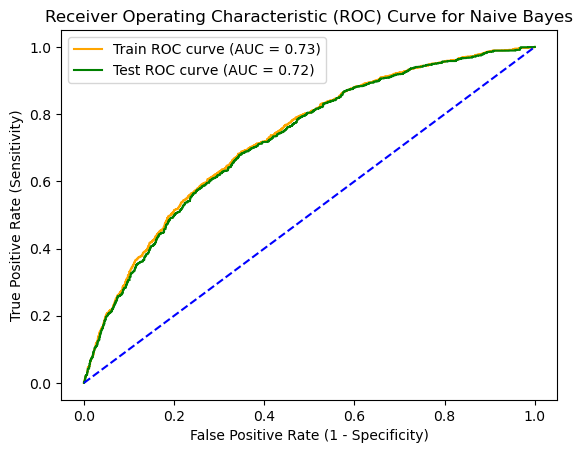

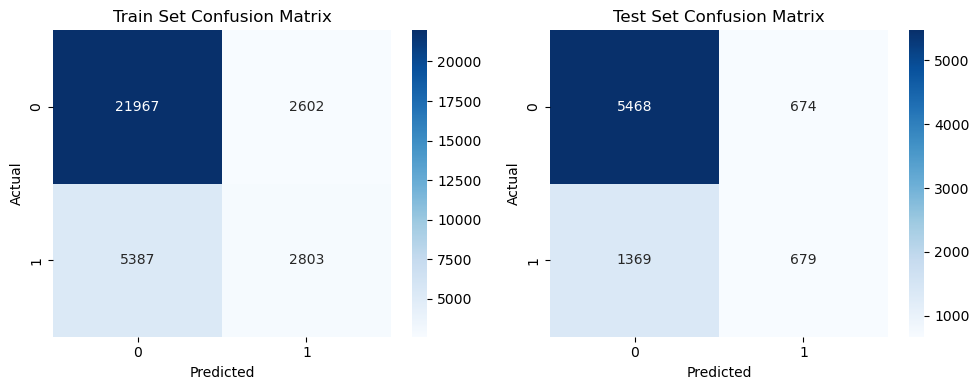

In [73]:
params_grid = {
    'var_smoothing': np.linspace(1e-10, 1e-2, num=1000)
    }

# instantiate a naive bayes model
nb = GaussianNB()

start_time = time.time() # start timer
# perform grid search
best_nb, best_params_nb = run_gridsearch(nb, params_grid, X_train, y_train)
end_time

# print time taken for grid search
print("Grid search execution took:", str(end_time - start_time), " seconds")
# print best parameters
print("Best parameters:", best_params_nb)

# train, fit and evaluate the model
train_fit_eval(best_nb, X_train, y_train, X_test, y_test)

# plot the roc curve
plot_roc_curve(y_train, best_nb.predict_proba(X_train)[:,1], y_test, best_nb.predict_proba(X_test)[:, 1], 'Naive Bayes')

# plot the confusion matrix
plot_confusion_matrix(y_train, best_nb.predict(X_train), y_test, best_nb.predict(X_test), 'Naive Bayes')

#### Naive Bayes Hyperparameter Tuning Results:
The Naive Bayes model did not improve much after hyperparameter tuning. All of the scores were < 1% better than the baseline model.

## Summary of Results
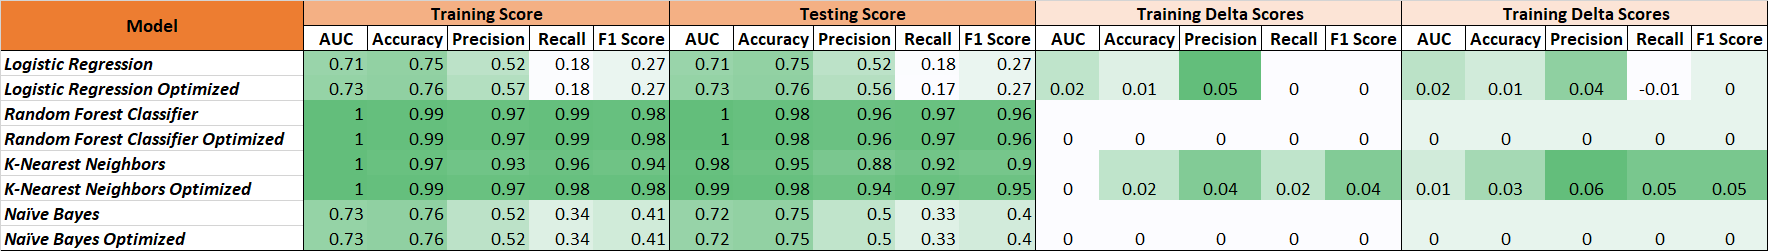